# Region of Boom

*Predicting specific metropolitan areas that are likely to experience a multifamily housing boom in the next two years.*

## By [Daniel Guerrero](https://alumni.codeup.com/students/839), [Alec Hartman](https://alumni.codeup.com/students/847), [Nick Joseph](https://alumni.codeup.com/students/848), & [Noah Melngailis](https://alumni.codeup.com/students/838) a.k.a [Data & Urban Development](https://github.com/hud-capstone/Data-and-Urban-Development)

## Table of Contents
- [Introduction](#Introduction)
    - [Executive Summary](#Executive-Summary)
    - [Project Origin & Stakeholder](#Project-Origin-&-Stakeholder)
- [Data Science Pipeline](#Data-Science-Pipeline)
- [Wrangle](#Wrangle)
    - [Data](#Data)
        - [FHA Data & Problems](#FHA-Data-&-Problems)
        - [New Data: Building Permit Surveys](#New-Data:-Building-Permit-Surveys)
    - [Acquire](#Acquire)
        - [Data Summary & Preliminary Exploration](#Data-Summary-&-Preliminary-Exploration)
    - [Prepare](#Prepare)
        - [Returning to Preliminary Exploration](#Returning-to-Preliminary-Exploration)
    - [Wrangle Conclusions](#Wrangle-Conclusions)
- [Preprocessing](#Preprocessing)
    - [Clustering](#Clustering)
        - [Cluster Exploration](#Cluster-Exploration)
            - [Random Samples](#Random-Samples)
            - [Hypothesis Testing with Clusters](#Hypothesis-Testing-with-Clusters)
        - [Clustering Conclusions](#Clustering-Conclusions)
    - [Label Creation](#Label-Creation)
        - [Label Exploration](#Label-Exploration)
            - [Hypothesis Testing with Labels](#Hypothesis-Testing-with-Labels)
        - [Label Creation Conclusions](#Label-Creation-Conclusions)
    - [Preprocessing Conclusions](#Preprocessing-Conclusions)
- [Modeling](#Modeling)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [KNN](#KNN)
    - [Evaluate](#Evaluate)
    - [Modeling Conclusions](#Modeling-Conclusions)
- [Prediction](#Prediction)
- [Conclusion](#Conclusion)

In [1]:
# import data science libraries
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [2]:
# global setting for DataFrames and visualizations
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

---

# Introduction

Welcome to the final report on our capstone project while enrolled with [Codeup](https://codeup.com/).

The primary purpose of this notebook is to document our processes and offer recommendations to our stakeholder, [TestFit](https://blog.testfit.io/testfit-home) (an architecture, engineering, and construction generative design software company). Additionally, this notebook serves as an exhibition of our talent for potential employers.

The following is a thorough investigation of multifamily housing trends in the United States (U.S.) over the last 23 years.

We hope you find our content to be both engaging and insightful!

## Executive Summary

1. Objective - Identify major metropolitan markets that are likely to experience significant high-density, multifamily housing infrastructure growth over the next two years.
2. Solution - When conducting exploratory analysis on historical high-density, multifamily housing data, we may unconver trends that will aid in creating a machine learning model to predict markets that are likely to see significant infrastructure growth over the next two years.
3. Result - A machine learning model that can predict emerging high-denisty, multifamily housing markets with 91% accuracy.

## Project Origin & Stakeholder

This project came into being when we offered our services to TestFit's CEO, [Clifton Harness](https://www.linkedin.com/in/cliftonharness/). When inquiring on how we might assist Clifton in prioritizing his limited resources, he posed the following research question to us:

> How many apartment units are being built in the U.S. everyday?

We then distilled Clifton's question into a data science research question:

> How many *high-density, multifamily structures* are being built in the U.S. everyday?

At this point we began researching data sets that demonstrated potential for answering our research question.

Our data science pipeline and conclusions are below. Enjoy!

---

# Data Science Pipeline

# Wrangle

## Data

The initial iteration of this project was performed using the United States Department of Housing and Urban Development (HUD) Federal Housing Administration (FHA) multifamily loan production data. After reaching an minimum viable product (MVP) with the aforementioned data, we as a team found that our analysis was inconclusive, and the data we had was insufficient to adequately answer the research question that spawned our capstone project.

At this point, we began working with *building permit survey data* from the U.S. Census Bureau which we found to be a more complete data set. The work done on the data set we aquired for our second iteration, which we believe is more compelling, is contained within this notebook. The initial iteration of our project can be found [here](https://nbviewer.jupyter.org/github/hud-capstone/capstone/blob/master/mvp_folder/mvp_notebook.ipynb).

### FHA Data & Problems

For our capstone, we were tasked with modeling multifamily housing *construction* in the U.S. over time. The FHA data we initially used was information on multifamily housing mortgages over the past 15 years. As we explored the data, we recognized some problems that needed to be overcome:

1. Not all construction that happens in the U.S. uses a FHA backed mortgage. As a result, we had limited insights on construction behavior in the private sector using the FHA data.
2. 80% of the data set was refinanced mortgages. There are many reasons to refinance a loan, but unpacking which of these refinances indicated refinancing a *construction* loan was out-of-scope for this project ([read more here](https://www.reonomy.com/blog/post/commercial-loan-refinance)). Ultimately, the activity that was of interest to our stakeholder was a minority of the data set.  
3. After reshaping our data to make a single observation for exploration and modeling (a market expressed as a city, state, and year), we were left with a small number of observations that provided us with continuous information for the time period, and many observations with zero values for the metrics of interest for our analysis.

Given these obstacles and our desire to deliver a quality solution to our stakeholder, we chose to move onto the building permit survey data set.
    
### New Data: Building Permit Surveys

Using the United States Census Bureau Building Permit Survey data, we were able to gain more insights and create value for our stakeholder. Below are several resources concerning the data set.

[United States Census Bureau Building Permits Survey](https://www.census.gov/construction/bps/): This link takes you to the main webpage where the data was sourced.

[ASCII files by State, Metropolitan Statistical Area (MSA), County or Place](https://www2.census.gov/econ/bps/): This is the Census Bureau's file system containing comma-separated text files of building permit surveys aggregated based on various geographical areas.

[MSA Folder](https://www2.census.gov/econ/bps/Metro/): We used data on the Metropolitan Statistical Area level of granularity found at this link.

[ASCII MSA Documentation](https://www2.census.gov/econ/bps/Documentation/msaasc.pdf): This is the documentation of the original features found in the resultant DataFrame generated when calling the `acquire_building_permits` function.

When referencing the documentation link above, one may notice the that the ASCII comma-separated text files contain both *estimates with imputation* and *reported* building permit survey data. We chose to use the estimated building permit survey data that contains imputations made by the Census Bureau as their imputation methods are almost certainly more robust than anything we can do to impute missing data for the reported surveys.

**Addtionally, all valuation metrics in the original data are expressed in thousands.**

An overview of our data acquisition process is detailed below.

## Acquire

All functions are stored in `wrangle.py`.

### Functions
- `acquire_building_permits` - This function acquires the MSA building permit survey data from the U.S. Census Bureau
- `rename_building_permit_columns` - Renames columns from the original text files storing the data
    - **Note**: This function is called within `acquire_building_permits`
    
By calling our `acquire_building_permits` function we are able to generate a pandas DataFrame, and begin preliminary exploration and preparation of the data. We'll store the resultant DataFrame in the `df` variable.

In [3]:
# storing data in df variable
df = wr.acquire_building_permits()

### Data Summary & Preliminary Exploration

In [4]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 8,382 observations and 29 features.


,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,7644.0,12.0,45.0,6074.0,48.0,665.0,60456.0,984.0,984.0,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
1,2019,430.0,48260.0,False,Weirton-Steubenville WV-OH,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,999.0,10180.0,False,Abilene TX,354.0,354.0,72824.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0,353.0,353.0,72596.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,566.0,49660.0,False,Youngstown-Warren-Boardman OH-PA,323.0,323.0,73182.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0,234.0,234.0,50054.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0
4,2019,558.0,48700.0,False,Williamsport PA,66.0,66.0,16215.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,49.0,12095.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8377,1997,6240.0,9999.0,False,Pine Bluff AR MSA,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0
8378,1997,6280.0,9999.0,False,Pittsburgh PA MSA,4432.0,4432.0,551173.0,66.0,132.0,9580.0,52.0,194.0,12291.0,102.0,1306.0,65021.0,3705.0,3705.0,481092.0,60.0,120.0,9251.0,45.0,173.0,12002.0,81.0,1111.0,56757.0
8379,1997,6320.0,9999.0,False,Pittsfield MA MSA,97.0,97.0,11578.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0,80.0,80.0,9447.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0
8380,1997,6340.0,9999.0,False,Pocatello ID MSA,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0


Currently, each observation in our `df` variable is the *estimated* and *reported* annual building permit survey data by metropolitan area aggregated annually from 1997 to 2019. We will need to reshape our data for exploration and modeling. We'll address this later.

For now, it important that we gain our bearings on the data.

Let's get some high-level information on our `df` variable.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8382 entries, 0 to 8381
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   survey_date                    8382 non-null   int64  
 1   csa_code                       8382 non-null   float64
 2   cbsa_code                      8382 non-null   float64
 3   moncov                         8382 non-null   bool   
 4   cbsa_name                      8382 non-null   object 
 5   one_unit_bldgs_est             8382 non-null   float64
 6   one_unit_units_est             8382 non-null   float64
 7   one_unit_value_est             8382 non-null   float64
 8   two_units_bldgs_est            8382 non-null   float64
 9   two_units_units_est            8382 non-null   float64
 10  two_units_value_est            8382 non-null   float64
 11  three_to_four_units_bldgs_est  8382 non-null   float64
 12  three_to_four_units_units_est  8382 non-null   f

While we conducted some minor cleaning of the data in our initial aquisition (which can be found in our `wrangle.py` script), this data set is relatively complete in nature. Each feature contains 8,382 non-null values.

As a reminder, the features of interest to our stakeholder are those that indicate *high-density*, multifamily housing. While duplexes, triplexes, and quadplexes are considered multifamily dwellings, we need to subset our data such that we are only considering high-density structures. Given this understanding, we chose to use the features displayed above that are prefixed with `five_or_more_units`.

Let's take a quick moment to demonstrate the differences between the estimated and reported high-density survey data by calling the `high_density_rep_v_est_difference` function.

In [6]:
ex.high_density_rep_v_est_difference(df)

There is an 8.20% absolute difference between the reported and estimated total number of high-density, multifamily 
    buildings in the dataset.

There is an 4.40% absolute difference between the reported and estimated total number of high-density, multifamily 
    units in the dataset.

There is an 3.90% absolute difference between the reported and estimated total valuation of high-density, multifamily 
    structures in the dataset.


We were comfortable with the differences between the reported and estimated data, and chose to use the estimated metrics for our analysis.

Pressing on...

Let's take a look at the distribution of our data.

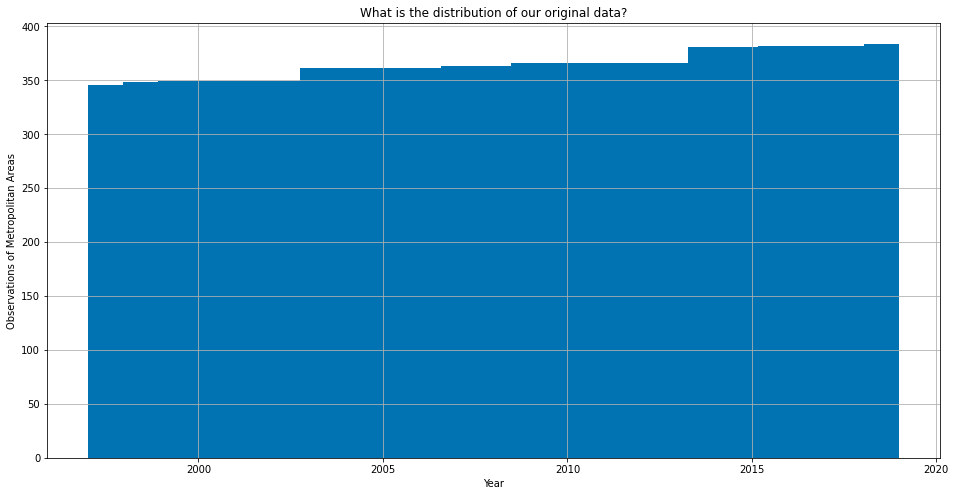

In [7]:
df.survey_date.hist(bins=len(df.survey_date.unique().tolist()))
plt.title("What is the distribution of our original data?")
plt.xlabel("Year")
plt.ylabel("Observations of Metropolitan Areas")
plt.show()

**Takeaway**: Looks like our data is relatively uniformly distributed with a steady increase of observations over time.

Let's take a look at the number of buildings for the top 20 metro areas

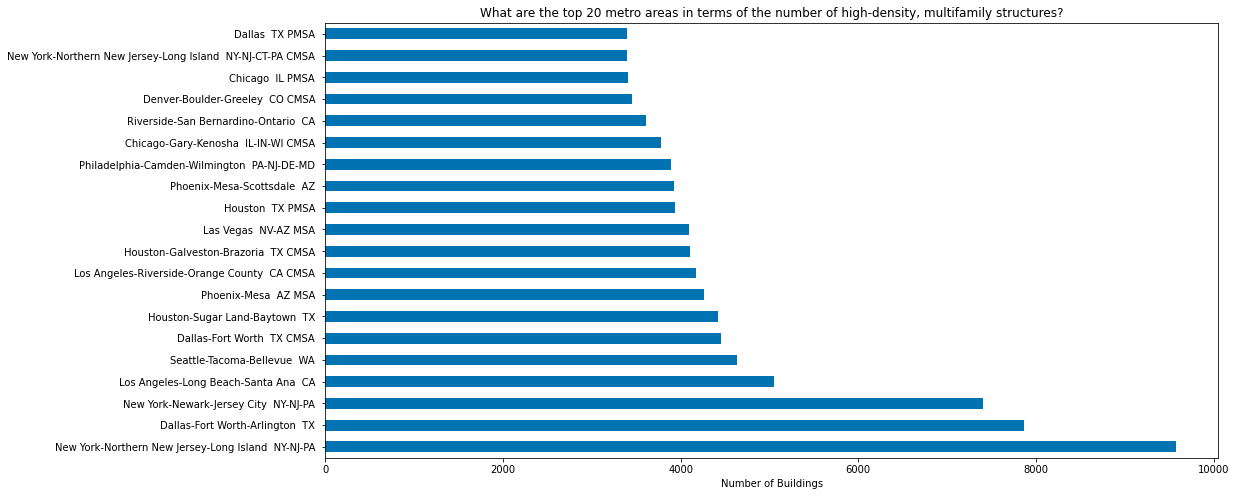

In [8]:
df.groupby("cbsa_name").five_or_more_units_bldgs_est.sum().sort_values(
    ascending=False
).nlargest(20).plot(kind="barh")
plt.title(
    "What are the top 20 metro areas in terms of the number of high-density, multifamily structures?"
)
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()

**Takeaway**: Not surprisingly, the NYC metro area tops the charts. Another consideration is the fact that we will need to standardize these metro area names to get unique metro observations. Let's handle that now before we continue on in our exploration so that our insights are more valuable.

---

## Prepare

Before we continue exploring, we must clean our data so that it is in a more useful format. As mentioned above, the biggest issue we face is the city name, labled in the DataFrame as `cbsa_name`. It seems that over time, the way the city name is recorded has changed, but the changes have not been applied retrospectively. Thus, we have several different formats that each city name can have. In fact, when looking at the number of ways that Austin, TX is formatted, we see that there are four unique values.

In [9]:
(
    df[(df.cbsa_name.str.contains("Austin")) | (df.cbsa_name.str.contains("AUSTIN"))]
    .cbsa_name.value_counts()   
)

Austin-Round Rock  TX                12
Austin-San Marcos  TX MSA             6
Austin-Round Rock-San Marcos  TX      4
Austin-Round Rock-Georgetown  TX      1
Name: cbsa_name, dtype: int64

To fix this problem, we explored the different ways in which the Austin metro area is named and formatted.

First, we found that there were three instances where the city names were capitalized. In order to standardize the names, we used the `.lower()` function transform the strings in our `cbsa_name` feature to contain only lowercase characters.

Next, we noticed that the number of instances a specfic metro area was captured in our data was very high. We found that as the city grew into nearby towns, those metro areas were grouped together. Ultimately, we chose to address this problem by removing the smaller town names from the `cbsa_name` feature and keep only the major city concerning the metro area. In our example, we keep Austin and removed all other mentions of San Marcos, Round Rock, and Georgetown. Then we used `.split()` to separate the city from the state, and stored the values in two separate columns. 

Once we cleaned most of the city name data, we found that there were still some duplicated metro areas, where the state was followed by either `MSA`, `SMSA` or `RMSA`. After doing some research, we found that these values were further breakdowns of the total reported metrics, and as such, it would be best for us to simply create an aggregated value. We proceeded by removing these values, used `.groupby()` to combine the data, and aggregated all the metrics based on unique combinations of a city, state, and year.

All of this work is stored in the `prep_building_permits` function below.

### Function
- `prep_building_permits` - This function creates the standardized `major_city` and `major_state` features out of the `cbsa_name` feature from our inital DataFrame. Additionally, this function summarizes all quantitative features in the DataFrame by grouping the `major_city`, `major_state`, and `survey_date` features together.

Let's use the function to transform our DataFrame.

In [10]:
df = wr.prep_building_permits(df)

In [11]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 8,269 observations and 30 features.


,major_city,major_state,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,Abilene,TX,1997,40.0,9999.0,False,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0
1,Abilene,TX,1998,40.0,9999.0,False,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abilene,TX,1999,40.0,9999.0,False,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abilene,TX,2000,40.0,9999.0,False,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0
4,Abilene,TX,2001,40.0,9999.0,False,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8264,Yuma,AZ,2015,999.0,49740.0,False,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0
8265,Yuma,AZ,2016,999.0,49740.0,False,890.0,890.0,137493.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0,824.0,824.0,131881.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0
8266,Yuma,AZ,2017,999.0,49740.0,False,1005.0,1005.0,163723.0,2.0,4.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0,993.0,993.0,161953.0,1.0,2.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0
8267,Yuma,AZ,2018,999.0,49740.0,False,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0


**Takeaway**: Now we have unique city, state, and year observations for our data! Let's revisit that horizontal bar plot we saw earlier.

### Returning to Preliminary Exploration

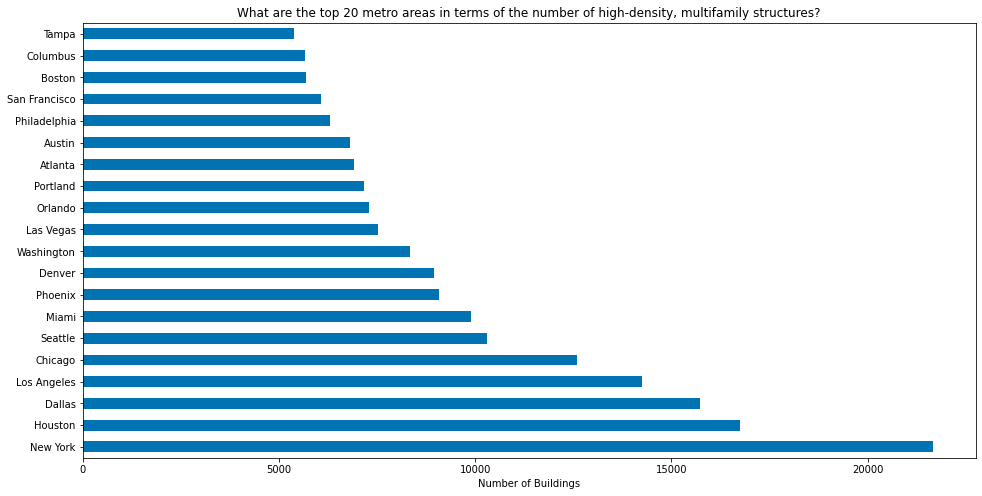

In [12]:
df.groupby("major_city").five_or_more_units_bldgs_est.sum().nlargest(20).plot(
    kind="barh"
)
plt.title(
    "What are the top 20 metro areas in terms of the number of high-density, multifamily structures?"
)
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()


**Takeaways**: The data looks significantly better. We lose a bit of granularity when we remove the surrounding towns from the metropolitan areas, but by organizing the data in this way we are able to gain a better, top level understanding of the trends. We see that NYC is still the biggest city, in terms of the number of high density, multifamily structures.

An interesting note is that it doesn't seem that this data follows the same pattern as population trends. While New York City is the most populated city in the U.S., we would expect to see Los Angeles and Chicago next. However, Los Angeles is fourth, in terms of number of multifamily housing structures, and Chicago is fifth. As a hypothesis, we suspect cities such as LA and Chicago have a more room for single family housing structures, whereas more densely populated cities (like NYC or Houston) don't have a lot of room to grow because of geographical limitations, and as a result are required to have more multifamily housing units. We'll keep this hypothesis in our back pocket for a later iteration of this project.

Onward...

Let's peak at the distribution of the estimated valuation of high-density, multifamily structures.

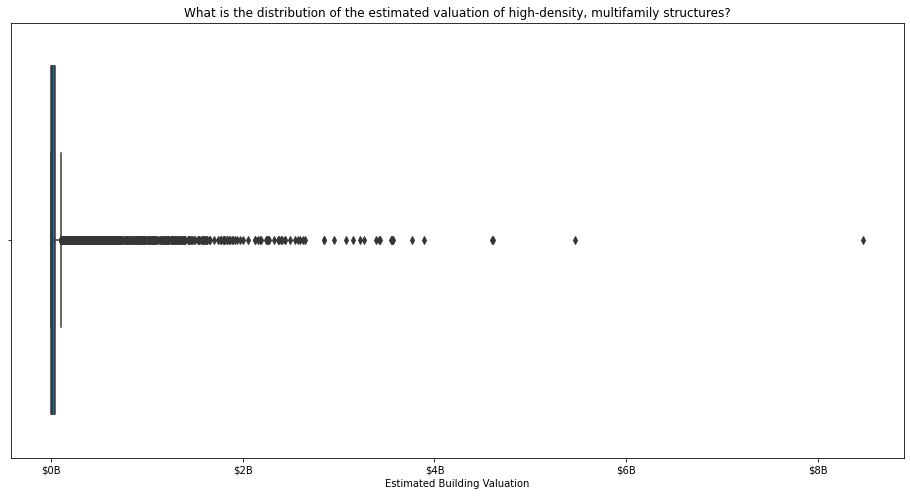

In [13]:
bp = sns.boxplot(df.five_or_more_units_value_est)
plt.title("What is the distribution of the estimated valuation of high-density, multifamily structures?")
plt.xlabel("Estimated Building Valuation")

# divide xticks (which are valuations currently expressed in thousands) by one million for better labels
xlabels = ["${:.0f}".format(x) + "B" for x in bp.get_xticks() / 1000000]
bp.set_xticklabels(xlabels)
plt.show()

**Takeaways**: Wow! Our data is very right-skewed with a lot of upper outliers. While this is not ideal, we decided not to remove the outliers, as it would mean losing precious data points, especially when time continuity is so important.

This will likely affect our statistical analysis later on, as we need a normally distributed data set for statistical testing to convey any valuable insights, but we ultimately believe this is the best decision. If these outliers become a problem, we address them later.

## Wrangle Conclusions

Now that we have acquired, prepared, and conducted some preliminary exploration on our data, we need to reshape the data set such that each observation is a specific market in time. This structure will provide more meaningful insights during the exploration process, and can be used for subsequent modeling. Let's do some preprocessing!

---

# Preprocessing

In order to get our data into a useable format for meaningful exploration and subsequent modeling we decided to group the data by city and state for each year as a means of identifying unique observations. Below is a brief summary of the functions found in the `preprocessing_permits.py` script which help to restructure our data into a more meaningful format.

## Functions

**Create Model DataFrame**
- `get_permits_model_df`: This function wrangles the data, selects only the features of relevance to our research (high-density, multifamily metrics), and gives those features more meaningful names. **Additionally, this function multiplies the valuation metric by 1,000 for a more explicit measure of valuation.**

**Feature Engineering**
- `calculate_avg_units_per_bldg`: This function calcuates the average number of units per building for an observation by dividing the total number of units by the total number of buildings. **This is our primary measure of density**.
- `calculate_value_per_bldg`: This function calcuates the average valuation per building for an observation by dividing the total valuation by the total number of buildings.
- `calculate_value_per_unit`: This function calcuates the average valuation per unit for an observation by dividing the total valuation by the total number of units.
- `calculate_city_state_high_density_bldgs_delta_pct`: This function calcuates the growth rate based on the total number of buildings for unique observations.
- `calculate_city_state_high_density_units_delta_pct`: This function calcuates the growth rate based on the total number of units for unique observations.
- `calculate_city_state_high_density_value_delta_pct`: This function calcuates the growth rate based on total valuation for unique observations.
- `calculate_evolution_index`: This function calculates the evolution index. Breifly, the evolution index is the measure of an observation's relative performance as compared to the greater U.S. multifamily housing market.
    - Markets that are on pace with the greater U.S. market will have a value of 1.
    - Markets that are outpacing the greater U.S. market will have a value *greater than* 1.
    - Markets that are underperforming in relation to the greater U.S. market will have a value *less than* 1.
    - Calculation: (1 + Observed Market Growth Rate) / (1 + Total U.S. Market Growth Rate)

   
- `add_new_features`: This function calls all of the above feature engineering functions.

**Clustering**
- `create_clusters`: This function creates clusters using the average units per building & evolution index features.

**Label, Split, & Scale**
- `filter_top_cities_building_permits`: This function transforms the DataFrame such that the outputs are only cities with 23 consecutive years of reported data, and cities where the observation had at least one high-density building built each year.
- `split_data`: This function splits our data into train, validate, and test for proper model training and evaluation.
- `return_values`: This is a helper function used to update scaled arrays and transform them into usable DataFrames (called within `min_max_scaler`).
- `min_max_scaler`: This is a helper function that scales the data.
- `create_model_labels`: This function creates labels out of our clusters.
- `prep_data_for_modeling_permits`: This function masks our DataFrame such that there are no null values for the relevant modeling features, creates an `observation_id` feature using the `city`, `state`, and `year` features, calls `split_data`, and calls `min_max_scaler`.

**Mother Function**
- `permits_preprocessing_mother_function`: This function wraps all of the functions documented here into one simple function.

Now let's use our functions.

First let's ensure we are working with the proper data by inspecting the `df` variable.

In [14]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 8,269 observations and 30 features.


,major_city,major_state,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,Abilene,TX,1997,40.0,9999.0,False,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0
1,Abilene,TX,1998,40.0,9999.0,False,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abilene,TX,1999,40.0,9999.0,False,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abilene,TX,2000,40.0,9999.0,False,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0
4,Abilene,TX,2001,40.0,9999.0,False,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0


Cool! Our DataFrame contains the same data returned to us when calling the `prep_building_permits` function. Now, let's get our data into the proper shape for modeling by calling `get_permits_model_df` on our `df` variable.

In [15]:
df = pr.get_permits_model_df()
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 6 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value
0,Abilene,TX,1997,0.0,0.0,0.0
1,Abilene,TX,1998,0.0,0.0,0.0
2,Abilene,TX,1999,0.0,0.0,0.0
3,Abilene,TX,2000,15.0,192.0,10200000.0
4,Abilene,TX,2001,13.0,192.0,6333000.0


Now our DataFrame observations are *unique markets* expressed as specific combinations of the `city`, `state`, and `year` features with summarized estimated high-denisty, multifamily housing metrics. However, we need some more meaningful features. Let's call our trusty `add_new_features` function on our `df` variable to help us out.

In [16]:
df = pr.add_new_features(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 15 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei
0,Abilene,TX,1997,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.054924e+10,NaN,NaN
1,Abilene,TX,1998,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.529787e+10,0.231085,NaN
2,Abilene,TX,1999,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.609590e+10,0.031545,NaN
3,Abilene,TX,2000,15.0,192.0,10200000.0,12.800000,680000.000000,53125.000,inf,inf,inf,2.742204e+10,0.050818,inf
4,Abilene,TX,2001,13.0,192.0,6333000.0,14.769231,487153.846154,32984.375,-0.133333,0.0,-0.379118,2.913103e+10,0.062322,0.584458


That's better! We have some very interesting feautures to both explore and help us create labels for our model.

Speaking of labels, there are none in our existing DataFrame. This is a problem since we plan on conducting supervised machine learning with our data.

Not to fear, we were able to create some labels using an unsupervised machine learning methodology called clustering! The process by which our labels were created is detailed below. Read on!

---
## Clustering

In this section we will document the method used to create labels for our data, clustering.

Before we get to the good stuff, we need to filter our data such that we are only considering cities with 23 *consecutive* years worth of high-density, multifamily housing construction. We can do this by calling our `filter_top_cities_building_permits` function.

In [17]:
df = pr.filter_top_cities_building_permits(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 2,990 observations & 16 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,NaN,NaN,Albany_NY
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY


This function is crucial for the accurate acessment of our data! We went from 8,000 observations to just under 3,000 when only considering cities with 23 consecutive years worth of high-density, multifamily housing construction. Additionally, we added a feature! `city_state` was created when calling the function above.

Now that our data has been reshaped and we have done some feature engineering, we can finally move into clustering!

By clustering, we can identify groups in our data that may not be readily apparent or labeled. Using our derived features we were able to create some valuable clusters that ultimately helped our team label the data for further exploration and modeling. Let's take a look at the process of creating our clusters.

First, lets ensure we are working with the proper data.

In [18]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,990 observations and 16 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,NaN,NaN,Albany_NY
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY


Looks good! We have our cities with 23 consecutive years worth of high-density, multifamily housing construction. Now's lets call our `create_clusters` function on our DataFrame, and assess our clusters.

In [19]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value, X = pr.create_clusters(df)
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 17 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,1.200626,Albany_NY,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,-1.118050,Albany_NY,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,-0.655825,Albany_NY,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,0.503915,Albany_NY,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,0.146820,Albany_NY,5


The first thing we would like to draw attention to is the fact that we lost 130 observations when we call `create_clusters` on our DataFrame. This is due to the fact that our clusters are created in part by using the evolution index (`ei`) which, as a reminder, is a specific market's growth rate relative to the greater U.S. market growth rate. So if there is no prior year observation to compare growth, improper values will be created when the calculation is run for each of the earliest year observations (1997) for every unique combination of a city and state in our DataFrame. Given this understanding, we need to remove any observations from our DataFrame where there are null values in order for our K-means clustering algorithm to work properly. Thus, we remove 130 observations where the year is equal to 1997 as there is no year-over-year growth rate calculation for those observations.

Now let's take a look at the other objects that are unpacked when we call `create_clusters`. First, `kmeans`.

In [20]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

This object is merely the model object used to cluster our data. We can see here that there are 6 clusters created as the `n_clusters` parameter is set to 6.

"Well, how did we arrive at 6 clusters?", you may be asking yourself. Great question, let us show you!

First, let's take a look at the features we used to cluster stored in the `X` variable.

In [21]:
# scaled features from create_clusters function
X.head()

,avg_units_per_bldg,ei
1,0.499727,1.200626
2,-0.493115,-1.118050
3,-0.398138,-0.655825
4,-1.307457,0.503915
5,-1.049695,0.146820


It's important to revisit the research question posed to us by our stakeholder when discussing the variables by which we clustered:

> How many high-density, multifamily structures are being built in the U.S. everyday?

When critically thinking on this question and the features at our disposal in the data, our team settled on the evolution index (`ei`) and average units per building (`avg_units_per_bldg`) as the proper features to use for clustering.

We have already established that we are working with high-density, multifamily data. However, we can further address our stakeholder's question by using the average units per building as a measure of density for specific markets. Additionally, our stakeholder is inherently wanting to turn a profit. We used the evolution index to identify markets that are likely to yield a significant return on investment (ROI). Used in combination, these variables created some very interesting clusters that proved invaluable to our project.

Finally, you may notice that these features are not the values you may have expected to see. This is because our features have been *scaled*. Let's take a look at the `scaler` object created when unpacking our `create_clusters` function.

In [22]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

We are using a `PowerTransformer` scaler in order to make our features more Gaussian-like (normally distributed). This scaler helps reduce the [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) (non-constant variance) of our data.

Now that we have scaled features, we can pass them into our trusty `plot_inertia` function in order to determine the appropriate number of clusters for our data.

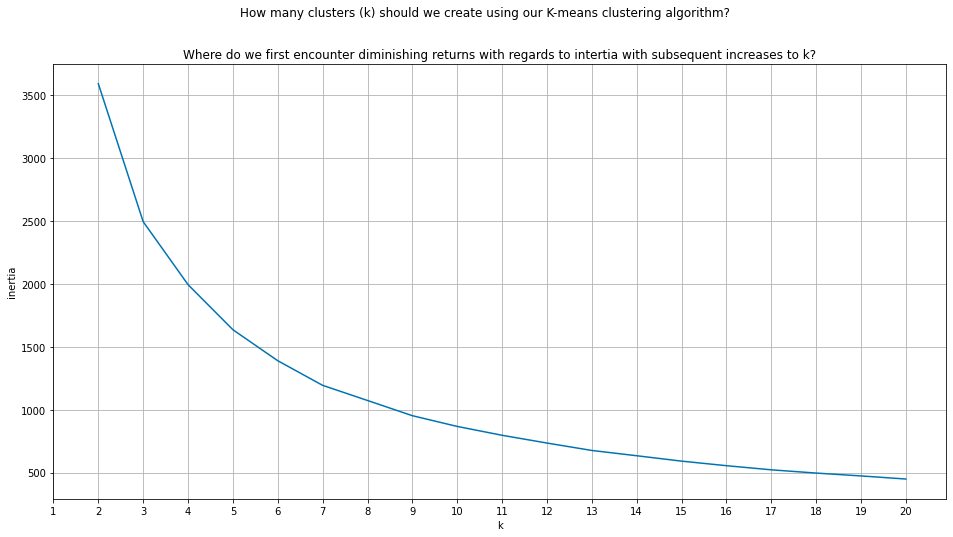

In [23]:
ex.plot_inertia(X)

Before interpreting the plot above, let's briefly define a couple terms as they relate to clustering.

> **centroid** - one of the cluster centers in K-means clustering

> **inertia** - sum of the squared distances from each point to it's assigned centroid

Essentially, inertia helps us define how many clusters should be created with K-means by telling us where the relative distance to the centroid for each point in a cluster is the smallest. For our analysis, it is important to create the *minimum necessary* clusters so that we are able to properly identify the differentiating characteristics of each cluster. The concept of dimishing returns is helpful for determining the number of clusters to create.

So, getting back to interpreting the plot above. We observe significant drops in inertia as we increment our k from 2 to 5 and less so thereafter. The case for the point at which we first encounter diminishing returns with each subsequent increase in k can be made for either a k of 6 or 7. We chose to create 6 clusters according to the inertia plot above.

Finally, we will use the two remaining objects created when unpacking the `create_clusters` function (`centroids` and `scaled_ei_threshold_value`) by calling the `visualize_clusters` function.

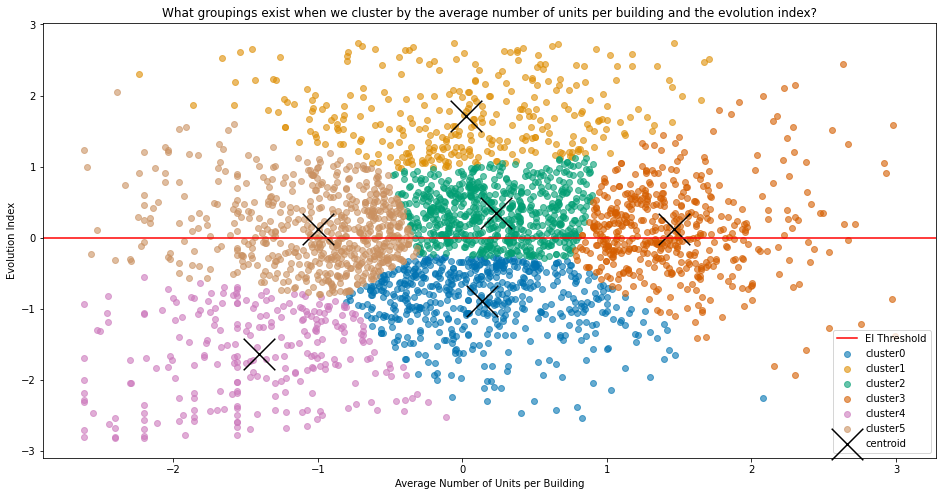

In [24]:
ex.visualize_clusters(df, centroids, scaled_ei_threshold_value)

It's important to reiterate that the features used to create our clusters are **scaled**. Why is this important? Well, by using the `PowerTransformer` scaler we transform our clustering features such that the distribution of the values in the features is *normalized*. Meaning, the zero values in the axes of the plot shown above are the *mean* values of the respective features. For the average number of units per building, the mean number of units per building is represented as 0 in the x-axis. When considering the evolution index, the 0 value on the y-axis is equivalent to the mean unscaled evolution index. The horizontal red line bisecting our scatterplot is labeled as the "EI Threshold." This threshold is equivalent to an unscaled evolution index of 1 (i.e, an EI of 1 means a market is growing at the same rate as the population, not outperforming or underperforming). The integers on either side of the zero value represent the number of *standard deviations* an observation is from the mean. The Xs are the centroids, or centers, of each respective cluster. Finally, each point on our plot has been set to have a transparency of 50%. This is important as we can identify where there are more observations taking on similar characteristics based on the darker shades in our clusters.

Okay, now let's interpret our clusters. Below is a brief description of the characteristics of each cluster as interpreted from the scatterplot above:

- `cluster0` - underperforming markets that are building an average number of units per building (i.e., low relative growth, average density)
- `cluster1` - markets outpacing the population that are building an average number of units per building (i.e., high relative growth, average density)
- `cluster2` - mixed relative growth markets that are building an average number of units per building (i.e., mixed relative growth, average density)
- `cluster3` - mixed relative growth markets that are building a high number of units per building (i.e., mixed relative growth, high density)
- `cluster4` - underperforming markets building a low number of units per building (i.e., low relative growth, low density)
- `cluster5` - mixed relative growth markets building a low number of units per building (i.e., mixed relative growth, low density)

Now, let's focus on the utility of these clusters.

Remember, since we have aggregated our data based on a unique combination of a city, state, and year, each obervation (or point on our plot) is a *specific market in time*.

If we are thinking as the stakeholder, we want to reap the profits of being established in a market that is growing or outpacing the greater U.S. multifamily housing market. Real estate is a long-term game. Thus, we need to recommend markets that are likely to see future movement from unprofitable clusters into more profitable clusters in *two years time*. How do we determine this?

---

### Cluster Exploration

Let's take a random sample from each cluster and plot the trajectory of that market over time to see if we can identify common patterns (or movement between clusters) that may indicate a future profitable multifamily housing market.

First, we need to ensure we're working with the proper data

In [25]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 17 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,1.200626,Albany_NY,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,-1.118050,Albany_NY,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,-0.655825,Albany_NY,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,0.503915,Albany_NY,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,0.146820,Albany_NY,5


Look's correct! We have our unique markets, our scaled features (`avg_units_per_bldg` and `ei`), and our clusters in the DataFrame.

Now, we need to *unscale* our clustering features so that the exploration done with them is more meaningful.

Let's ensure the `scaler` object is what we think it is.

In [26]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

Check. Now, let's use it revert our clustering features to their original, unscaled values.

In [27]:
# unscaling features using inverse_transform
df[["avg_units_per_bldg", "ei"]] = scaler.inverse_transform(df[["avg_units_per_bldg", "ei"]])

print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 17 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,1
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,5
5,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,1.110072,Albany_NY,5


We see in the DataFrame above that our clustering features have returned to their original, unscaled values. This will make the exploration process more explicit and interpretable.

Before we begin exploring, let's get an understanding of the sizes of our clusters. As a reminder, a market is expressed as unique city, state, and year combination.

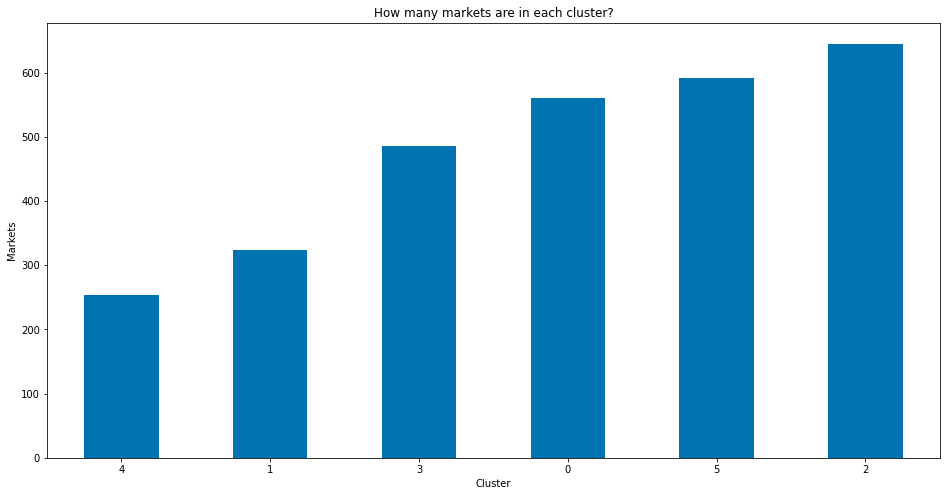

In [28]:
# how many observation per cluster?
df.groupby("cluster").city.count().sort_values().plot.bar()
plt.xticks(rotation=0)
plt.title("How many markets are in each cluster?")
plt.xlabel("Cluster")
plt.ylabel("Markets")
plt.show()

**Note**: Our clusters above are ordered from the fewest observations to the most, not sequentially.

**Takeaway**: It is interesting to see that the majority of markets are found in cluster 2. This means that the majority of markets in the U.S. were, at one point, largely outperforming the market, but still building an average amount of units. 

Another interesting takeaway is that cluster 4 seems to have the smallest number of markets. This might mean that cluster 4 is a more uncommon, or shorter, phase that a city undergoes as it changes over time. 

Hopefully, we will be able better to understand what each cluster represents as we carry on with the exploration of a random sample from each cluster.

---

#### Random Samples

Our frame of mind that brought us to the necessity of exploring a random sample from each cluster was influenced by the desire to understand the trends that led a market to be assigned to a particular cluster based on it's intersection of the evolution index and the average units per building.

Below, we have plotted the trajectory of each city from our random samples from 1998 to 2019 and the clusters that each market moved among to over time using the specific market's growth rate plotted against the growth rate of the greater U.S. multifamily housing market.

Let's begin our exploration by taking a sample from cluster 0.

In [29]:
# cluster 0 sample
# df[df.cluster == 0].sample()
df[(df.city == "Atlanta") & (df.state == "GA") & (df.year == 2009)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
127,Atlanta,GA,2009,36.0,994.0,105936000.0,27.611111,2.942667e+06,106575.452716,-0.777778,-0.859723,-0.844285,1.005604e+10,-0.608193,0.397428,Atlanta_GA,0


We chose to explore Atlanta, Georgia in 2009 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 0 as seen in the observation of our DataFrame above. The `.sample()` function is commented out in the cell above so that the subsequent analysis is consistent.

Let's plot the trajectory of our sample market.

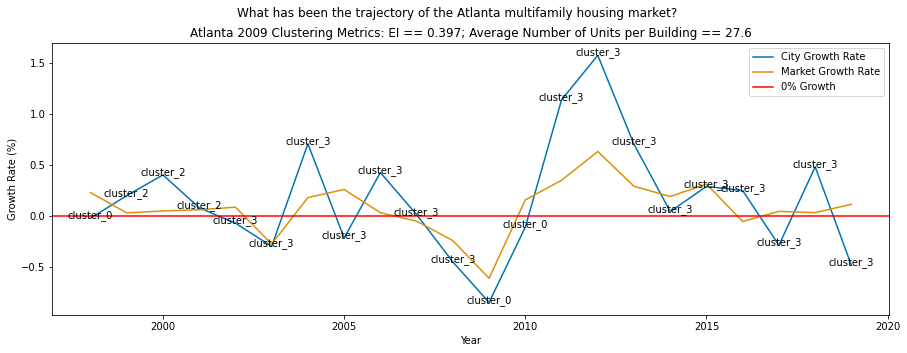

In [30]:
ex.growth_rate_line_plot(df, "Atlanta", 2009)

**Takeaways**: The Atlanta multifamily housing market saw a simultaneous decline along with the greater U.S. multifamily housing market in 2009, and a subsequent peak in 2012. Additionally, for the years observed in our dataset, Atlanta has not entered cluster 1 which we have interpreted as high growth in relation to the greater U.S. market.

Let's see what our cluster 1 sample has in store.

In [31]:
# cluster 1 sample
# df[df.cluster == 1].sample()
df[(df.city == "Colorado Springs") & (df.state == "CO") & (df.year == 2010)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
680,Colorado Springs,CO,2010,2.0,77.0,6441000.0,38.5,3220500.0,83649.350649,1.0,8.625,7.101887,1.165572e+10,0.159076,6.989951,Colorado Springs_CO,1


We chose to explore Colorado Springs, Colorado in 2010 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 1 as seen in the observation of our DataFrame above.

Let's plot the trajectory of our sample market.

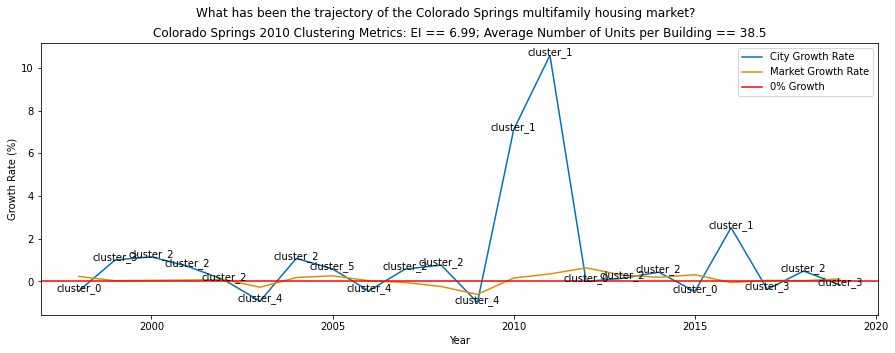

In [32]:
ex.growth_rate_line_plot(df, "Colorado Springs", 2010)

**Takeaways**: The Colorado Springs multifamily housing market generally fluctuates with the the greater U.S. multifamily housing market with the exceptions of the years 2010, 2011 and 2016. What happened in 2010 that caused Colorado Springs to perform at almost 7 times the market performance?

Let's see if we can start to identify some consistent trends of cluster movement by checking out a sample market from cluster 2.

In [33]:
# cluster 2 sample
# df[df.cluster == 2].sample()
df[(df.city == "Dallas") & (df.state == "TX") & (df.year == 2010)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
772,Dallas,TX,2010,203.0,4990.0,479537000.0,24.581281,2.362251e+06,96099.599198,-0.132479,-0.158942,-0.020824,1.165572e+10,0.159076,0.84479,Dallas_TX,2


We chose to explore Dallas, Texas in 2010 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 2 as seen in the observation of our DataFrame above.

Let's plot the trajectory of our sample market.

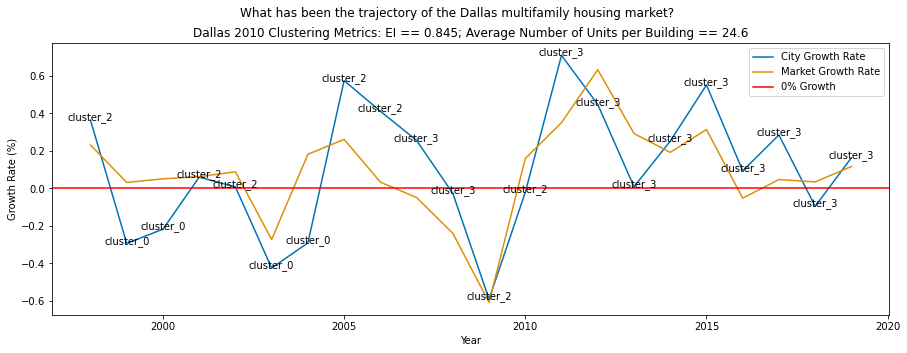

In [34]:
ex.growth_rate_line_plot(df, "Dallas", 2010)

**Takeaways**: The Dallas multifamily housing market generally adheres to the trends displayed by the greater U.S. multifamily housing market. Thus far, 2009 is consistently a trough in the multifamily housing market. Makes sense considering the Great Recession. Additionally, we see that cluster 0 may be characterized by a significant downward deviation from the greater U.S. multifamily housing market. We should form a couple hypotheses to test:

**What does the *greater U.S. market* growth rate look like for each cluster?**

Here we are considering the  growth rate for the U.S. market as a whole based on each cluster.

$H_0$: The mean U.S. market growth rate for all clusters is the same.

$H_a$: The mean U.S. market growth rate for all clusters is different.

**What do the *specific market* growth rates look like for each cluster?**

With this question, we are interested in how a specific market grew over time and the cluster to which that market was grouped.

$H_0$: The mean market growth rate for all clusters is the same.

$H_a$: The mean market growth rate for all clusters is different.

We will return to this hypotheses later. On to our cluster 3 sample.

In [35]:
# cluster 3 sample
# df[df.cluster == 3].sample()
df[(df.city == "Spokane") & (df.state == "WA") & (df.year == 2011)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
2613,Spokane,WA,2011,32.0,981.0,90632000.0,30.65625,2832250.0,92387.359837,-0.135135,0.513889,0.451227,1.574184e+10,0.350568,1.074531,Spokane_WA,3


We chose to explore Spokane, Washington in 2011 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 3 as seen in the observation of our DataFrame above.

Let's plot the trajectory of our sample market.

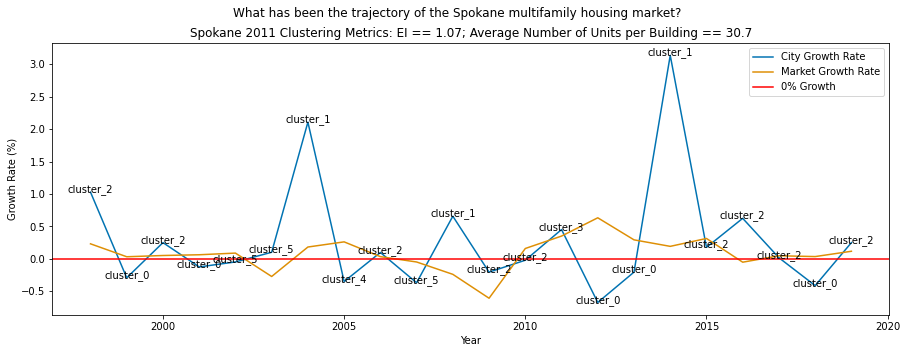

In [36]:
ex.growth_rate_line_plot(df, "Spokane", 2011)

**Takeaways**: Oddly enough, Spokane saw growth in 2008 and, perhaps, faired the Great Recession relatively well. Again, here we see that cluster 1 may be characterized by significant peaks in growth. In this sample, cluster 0 may be characterized by shrinking markets. Let's form a couple hypotheses concerning the metric used to calculate the growth rates - market valuation:

**What does the distribution of the *greater U.S. market* valuation look like for each cluster?**

In this question, we are asking what the distribution of the U.S. multifamily housing market valuation *as a whole* looks like depending on the cluster.

$H_0$: The mean U.S. market valuation for all clusters is the same.

$H_a$: The mean U.S. market valuation for all clusters is different.

**What does the distribution of a *unique market's* valuation look like for each cluster?**

This question is different from the one above we will be investigating *individual metropolitan areas* with this question where as above we were asking a question concering the U.S. market as a whole.

$H_0$: The mean market valuation for all clusters is the same.

$H_a$: The mean market valuation for all clusters is different.

Moving on to our cluster 4 sample...

In [37]:
# cluster 4 sample
# df[df.cluster == 4].sample()
df[(df.city == "Lubbock") & (df.state == "TX") & (df.year == 2018)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
1654,Lubbock,TX,2018,5.0,69.0,7049000.0,13.8,1409800.0,102159.42029,-0.951923,-0.909922,-0.916295,5.336251e+10,0.034393,0.080922,Lubbock_TX,4


We chose to explore Lubbock, Texas in 2018 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 4 as seen in the observation of our DataFrame above.

Let's plot the trajectory of our sample market.

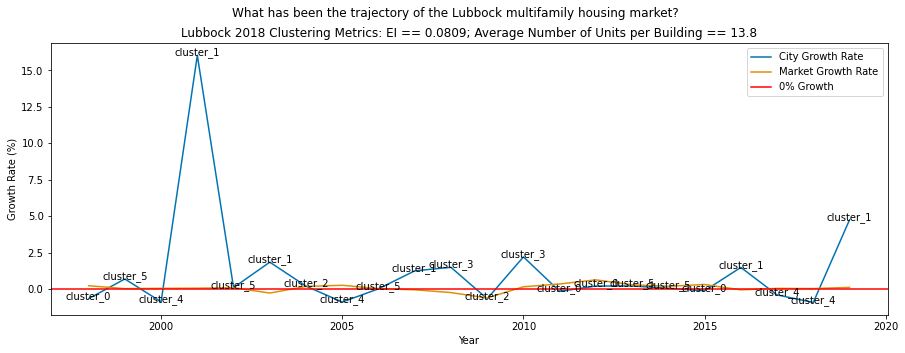

In [38]:
ex.growth_rate_line_plot(df, "Lubbock", 2018)

**Takeaways**: Wow! The 2001 growth rate in Lubbock dwarfs almost all other observations seen here. Most of the peaks here are found in clusters 1 or 3. Meanwhile, the troughs are predominantly found in cluster 4.

Finally, let's check out our cluster 5 sample.

In [39]:
# cluster 5 sample
# df[df.cluster == 5].sample()
df[(df.city == "Naples") & (df.state == "FL") & (df.year == 2007)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,cluster
1850,Naples,FL,2007,75.0,829.0,208379000.0,11.053333,2.778387e+06,251361.881785,-0.184783,-0.189638,-0.078756,3.375194e+10,-0.049083,0.968795,Naples_FL,5


We chose to explore Naples, Florida in 2007 using the `.sample()` function on a DataFrame filtered for only those observations in cluster 5 as seen in the observation of our DataFrame above.

Let's plot the trajectory of our sample market.

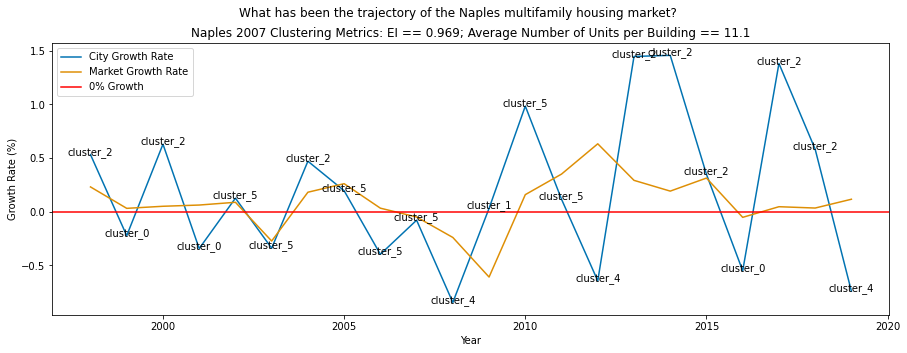

In [40]:
ex.growth_rate_line_plot(df, "Naples", 2007)

**Takeaways**: Naples is perhaps the best sample yet for observing the mixed growth that we interpreted as a  characteristic of cluster 5. The majority of the peaks here are found in cluster 2. The troughs, however, are spread across clusters 0, 4, and 5. 

Now that we have explored the trajectory of our sample markets from each cluster in terms of growth rates, we should take some time to explore the variables we used in our clustering.

First, we need to explore the evolution index. While the evolution index is a measure of growth, it is a slightly different metric from the growth rates expressed in the time series analysis conducted above. Let's formulate a hypothesis to test concerning the evolution index:

**What does the evolution index look like for each cluster?**

$H_0$: The mean evolution index for all clusters is the same.

$H_a$: The mean evolution index for all clusters is different.

Additionally, we need to explore *the metrics used to calculate* our measure of density for each cluster, average units per building. Below are two hypotheses, one for high-density units and one for high-density buildings.

**Do the total number of high-density units vary based on cluster?**

$H_0$: The mean units for all clusters is the same.

$H_a$: The mean units for all clusters is different.

**What does the distribution of high density buildings look like for each cluster?**

$H_0$: The mean number of high density buildings for all clusters is the same.

$H_a$: The mean number of high density buildings for all clusters is different.

Wow! We are coming away with seven unique hypotheses to test as a result of our time series analysis. How exciting! Let's get into it!

---

#### Hypothesis Testing with Clusters

Let's return to our hypothesis concerning valuation stated based on the assumptions we fromulated in our exploration process.

It's important to establish a high level of confidence when we are conducting hypothesis testing. For the following hypothesis tests, we will reject or fail to reject the null hypothses with 99% confidence as expressed in the alpha variable below:

In [41]:
# 99% confidence level
alpha = .01

Let us proceed with our first statistical test.

##### What does the distribution of the greater U.S. market valuation look like for each cluster?

$H_0$: The mean U.S. market valuation for all clusters is the same.

$H_a$: The mean U.S. market valuation for all clusters is different.

In [42]:
cluster_0 = df[df.cluster == 0].market_volume
cluster_1 = df[df.cluster == 1].market_volume
cluster_2 = df[df.cluster == 2].market_volume
cluster_3 = df[df.cluster == 3].market_volume
cluster_4 = df[df.cluster == 4].market_volume
cluster_5 = df[df.cluster == 5].market_volume

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 44.32557903888665
  p-value = 3.5666516499157076e-44

Reject null hypothesis


**Takeaway**: Based on our statistical testing we reject the null hypothesis. The mean market valuation for all clusters is *not* the same.

It's valuable to visualize the distibution of market valuation among our clusters.

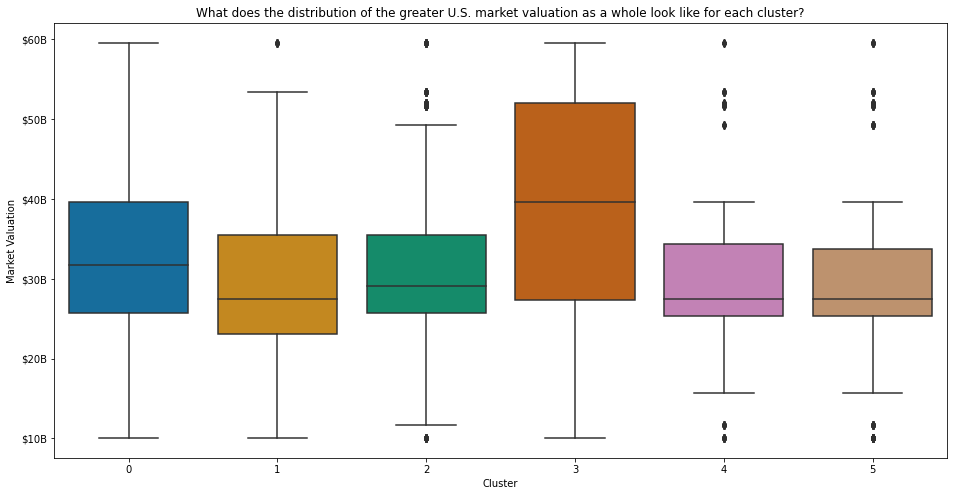

In [43]:
ex.mkt_value_dist_boxplot(df)

**Takeaway**: By observing the boxplot above, we can see that cluster 3 appears to have a different mean market valuation from the other clusters. What does this convey about our clusters? This could potentially indicate that cluster 3 is the most *competitive* cluster as the greater U.S. multifamily housing market as a whole is performing at a high level. Thus, outperforming the market when in cluster 3 may indicate a truly lucrative opportunity for our stakeholder.

Let's attempt to disprove the speculation above by running a one sample T-Test.

$H_0$: The mean market valuation for cluster 3 is the same as the population.

$H_a$: The mean market valuation for cluster 3 is different from the population.

In [44]:
cluster_3 = df[df.cluster == 3].market_volume

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_3, df.market_volume.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 11.421077684922484
  p-value = 6.414123594358693e-27

Reject null hypothesis


**Takeaway**: By rejecting the null hypothesis, we are able to confidently move forward with the assumption that the mean market valuation for cluster 3 is *not* the same as the population.

Next, let's take a look at the *growth rate* for the greater U.S. market.

##### What does the greater U.S. market growth rate look like for each cluster?

$H_0$: The mean U.S. market growth rate for all clusters is the same.

$H_a$: The mean U.S. market growth rate for all clusters is different.

In [45]:
cluster_0 = df[df.cluster == 0].market_volume_delta_pct
cluster_1 = df[df.cluster == 1].market_volume_delta_pct
cluster_2 = df[df.cluster == 2].market_volume_delta_pct
cluster_3 = df[df.cluster == 3].market_volume_delta_pct
cluster_4 = df[df.cluster == 4].market_volume_delta_pct
cluster_5 = df[df.cluster == 5].market_volume_delta_pct

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 7.0934638377928305
  p-value = 1.3307138920653816e-06

Reject null hypothesis


**Takeaway**: According to our statistical test, we reject our null hypothesis. The mean U.S. market growth rate for all clusters is *not* the same.

Let's illustrate this point.

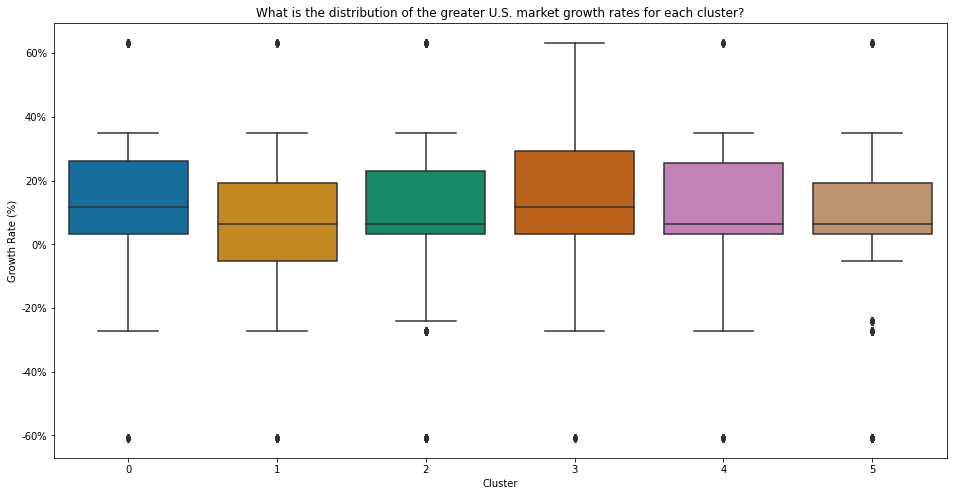

In [46]:
ex.us_mkt_growth_dist_boxplot(df)

**Takeaway**: Now this is an interesting boxplot! This visualization reinforces our assumtion of cluster 3 being the most competitive cluster. We observe here that the upper interquartile range for cluster 3 is the highest among our clusters. 

Let's formulate another hypothesis that could perhaps reinforce our speculation of cluster 3 being the most competitive cluster.

$H_0$: The mean U.S. market growth rate for cluster 3 is the same as the population.

$H_a$: The mean U.S. market growth rate for cluster 3 is different from the population.

In [47]:
cluster_3 = df[df.cluster == 3].market_volume_delta_pct

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_3, df.market_volume_delta_pct.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 3.1157431015632917
  p-value = 0.0019435630015871628

Reject null hypothesis


**Takeaway**: In rejecting our null hypothesis, we have reinforced our assumption of cluster 3 being the most competitive cluster based on both the greater U.S. market valuation and growth rate.

Let's drill down into specific market valuation and growth rates by proceeding with our hypothesis testing.

##### What does the distribution of a unique market's valuation look like for each cluster?

$H_0$: The mean market valuation for all clusters is the same.

$H_a$: The mean market valuation for all clusters is different.

In [48]:
cluster_0 = df[df.cluster == 0].total_high_density_value
cluster_1 = df[df.cluster == 1].total_high_density_value
cluster_2 = df[df.cluster == 2].total_high_density_value
cluster_3 = df[df.cluster == 3].total_high_density_value
cluster_4 = df[df.cluster == 4].total_high_density_value
cluster_5 = df[df.cluster == 5].total_high_density_value

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 136.948123608147
  p-value = 1.8456975829822653e-130

Reject null hypothesis


**Takeaway**: Based on our ANOVA test, we have rejected our null hypothesis.

Let's visualize how the distributions of market valuation differ from cluster to cluster.

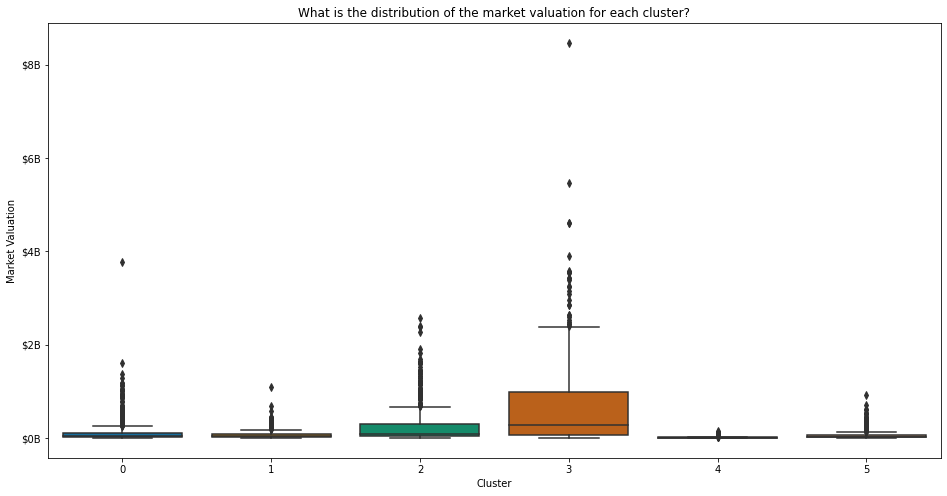

In [49]:
ex.unique_mkt_value_dist_boxplot(df)

**Takeaway**: The mean market valuation for cluster 3 appears to be different from the other clusters. Let's formulate a hypothesis to test what we are percieving from the boxplot above.

$H_0$: The mean market valuation for cluster 3 is the same as the population.

$H_a$: The mean market valuation for cluster 3 is different from the population.

In [50]:
cluster_3 = df[df.cluster == 3].total_high_density_value

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_3, df.total_high_density_value.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 10.697291752710555
  p-value = 4.028761917137045e-24

Reject null hypothesis


**Takeaway**: By rejecting the null hypothesis, we can proceed with assumption that the mean market valuation for cluster 3 is *not* the same as the population.

For our next hypothesis test, we will examine the growth rates of specific markets.

##### What do the specific market growth rates look like for each cluster?

$H_0$: The mean market growth rate for all clusters is the same.

$H_a$: The mean market growth rate for all clusters is different.

In [51]:
cluster_0 = df[df.cluster == 0].city_state_high_density_value_delta_pct
cluster_1 = df[df.cluster == 1].city_state_high_density_value_delta_pct
cluster_2 = df[df.cluster == 2].city_state_high_density_value_delta_pct
cluster_3 = df[df.cluster == 3].city_state_high_density_value_delta_pct
cluster_4 = df[df.cluster == 4].city_state_high_density_value_delta_pct
cluster_5 = df[df.cluster == 5].city_state_high_density_value_delta_pct

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 208.88046111342558
  p-value = 3.0856335618289437e-190

Reject null hypothesis


**Takeaway**: Since our p-value is *much* smaller than our alpha, we reject our null hypothesis with 99% confidence based on our ANOVA test. Thus, we can confidently assume that the mean growth rate for all clusters is *not* the same.

Let's take a look at a visualization to help us grasp the difference in the growth rates among clusters. 

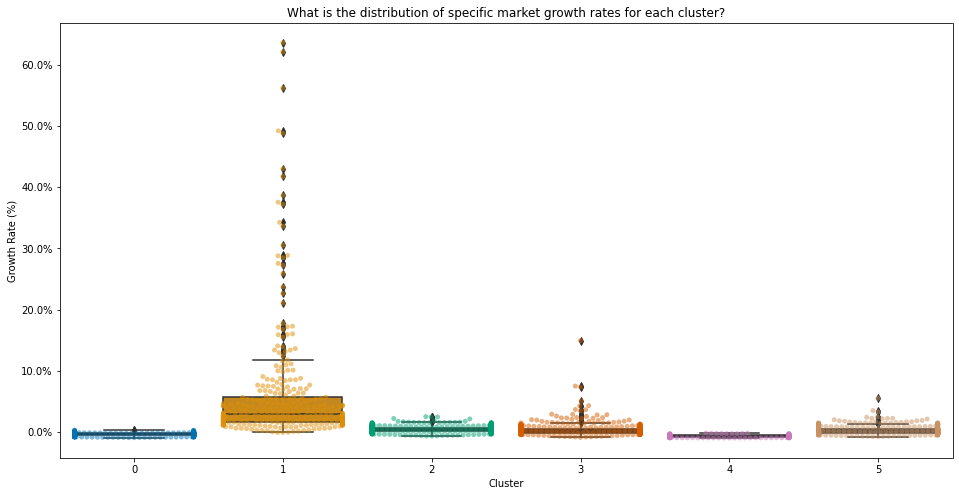

In [52]:
ex.growth_rate_dist_comboplot(df)

**Takeaway**: By combining a boxplot and a swarmplot, we are able to illustrate the distribution of the growth rates by cluster more explicitly than simply using one or the other. The most clear takeaway here is that our growth rates are not normally distributed. Additionally, we can see how the mean growth rate for cluster 1 may be higher than most of the other clusters' upper interquartile range. This may indicate that the markets found in cluster 1 are outperforming all other clusters in terms of growth. Let's run a one sample T-Test to test our speculation.

$H_0$: The mean mean growth rate for cluster 1 is the same as the population.

$H_a$: The mean mean growth rate for cluster 1 is different from the population.

In [53]:
cluster_1 = df[df.cluster == 1].city_state_high_density_value_delta_pct

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_1, df.city_state_high_density_value_delta_pct.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 10.202862884065292
  p-value = 2.308631781465109e-21

Reject null hypothesis


**Takeaway**: The result of our hypothesis testing with the growth rates indicates that the mean growth rate for cluster 1 is *not* the same as the population.

##### What does the evolution index look like for each cluster?

$H_0$: The mean evolution index for all clusters is the same.

$H_a$: The mean evolution index for all clusters is different.

In [54]:
cluster_0 = df[df.cluster == 0].ei
cluster_1 = df[df.cluster == 1].ei
cluster_2 = df[df.cluster == 2].ei
cluster_3 = df[df.cluster == 3].ei
cluster_4 = df[df.cluster == 4].ei
cluster_5 = df[df.cluster == 5].ei

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 221.23758383614881
  p-value = 5.90596440146399e-200

Reject null hypothesis


**Takeaway**: The resultant p-value from our statistical testing is incredibly small. Consequently, we reject our null hypothesis meaning we can assume, with 99% confidence, that the mean evolution index for all clusters is *not* the same.

Let's use a combination plot as we saw above to visualize the distribution the evolution index by cluster.

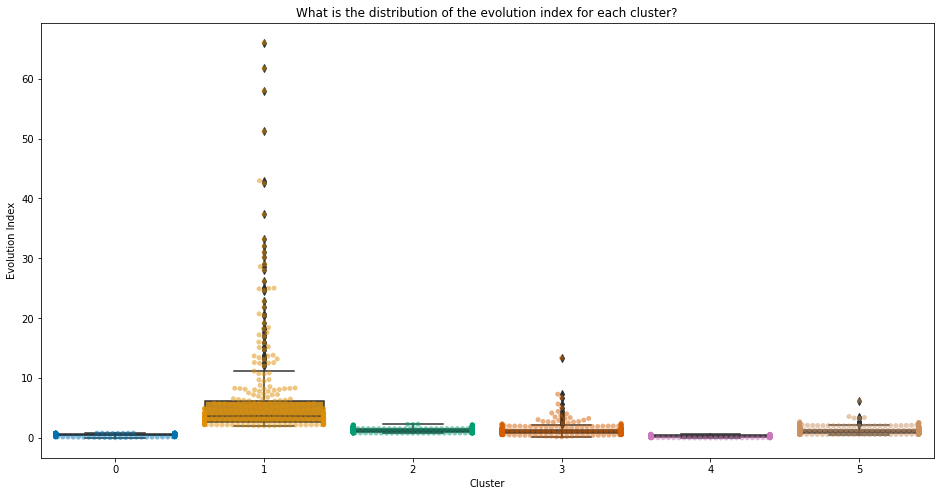

In [55]:
ex.ei_dist_comboplot(df)

**Takeaway**: Cluster 1 appears to have a higher mean evolution index than the rest of the clusters. This visualization reinforces the interpretation of cluster 1 being the highest performing cluster as documented when analyzing our visualization in the previous section.

Let's test our supposition using a one sample T-Test.

In [56]:
cluster_1 = df[df.cluster == 1].ei

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_1, df.ei.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 10.469668165994674
  p-value = 2.856676505816751e-22

Reject null hypothesis


**Takeaway**: The mean evolution index for cluster 1 is indeed *not* the same as the population. We can confidently assume that the mean evolution index for cluster one is different from all other clusters.

Let's press on with our next hypothesis test concerning unit density as it relates to cluster creation.

##### Do the total number of high-density units vary based on cluster?

$H_0$: The mean units for all clusters is the same.

$H_a$: The mean units for all clusters is different.

In [57]:
cluster_0 = df[df.cluster == 0].total_high_density_units
cluster_1 = df[df.cluster == 1].total_high_density_units
cluster_2 = df[df.cluster == 2].total_high_density_units
cluster_3 = df[df.cluster == 3].total_high_density_units
cluster_4 = df[df.cluster == 4].total_high_density_units
cluster_5 = df[df.cluster == 5].total_high_density_units

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 99.09386514540265
  p-value = 1.4398287158483167e-96

Reject null hypothesis


**Takeaway**: Once again, we have rejected our null hypothesis. The mean number of high density units per cluster is *not* the same.

Let's make a visualization that helps to illustrate this point.

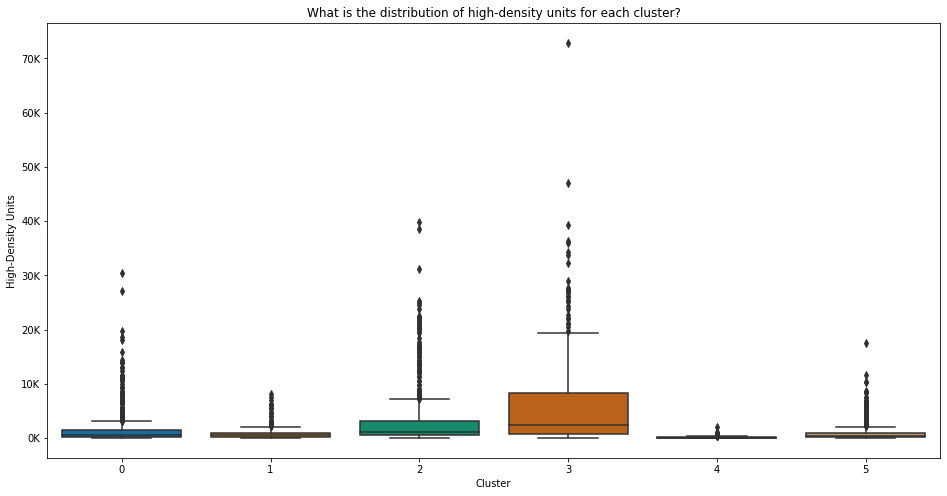

In [58]:
ex.unit_dist_boxplot(df)

**Takeaway**: Looks like cluster 3 may have the highest mean units among all clusters. We'll run a T-Test below in an attempt to disprove this conjecture.

$H_0$: The mean units for cluster 3 is the same as the population.

$H_a$: The mean units for cluster 3 is different from the population.

In [59]:
cluster_3 = df[df.cluster == 3].total_high_density_units

# one sample T-Test
tstat, pvalue = stats.ttest_1samp(cluster_3, df.total_high_density_units.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = 9.758922345756623
  p-value = 1.1613241975268494e-20

Reject null hypothesis


**Takaway**: Based on our statistical testing, we are able to move forward operating under the assumption that the mean units for cluster 3 is *not* the same as the population.

For our final hypothesis test with our clusters, we will inspect how the number of high-density buildings differ depending on the cluster.

##### What does the distribution of high density buildings look like for each cluster?

$H_0$: The mean number of high density buildings for all clusters is the same.

$H_a$: The mean number of high density buildings for all clusters is different.

In [60]:
cluster_0 = df[df.cluster == 0].total_high_density_bldgs
cluster_1 = df[df.cluster == 1].total_high_density_bldgs
cluster_2 = df[df.cluster == 2].total_high_density_bldgs
cluster_3 = df[df.cluster == 3].total_high_density_bldgs
cluster_4 = df[df.cluster == 4].total_high_density_bldgs
cluster_5 = df[df.cluster == 5].total_high_density_bldgs

# ANOVA
stat, pvalue = stats.f_oneway(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, cluster_5)

ex.get_stat_test_results(stat, pvalue, alpha)

statistic = 37.76957423120896
  p-value = 1.2491211307714952e-37

Reject null hypothesis


**Takeaway**: We are undefeated in our statistcal testing. By rejecting our null hypothesis, we are able to state with 99% confidence that the mean number of high density buildings for all clusters is *not* the same.

Once again, we will visualize our data in order to demonstrate the distribution of the number of high-density buildings by cluster.

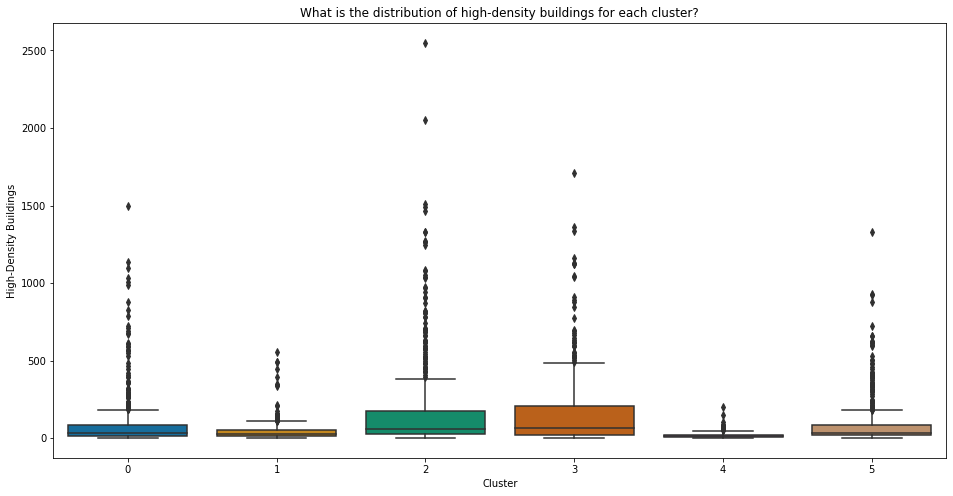

In [61]:
ex.building_dist_boxplot(df)

**Takeaway**: This visualization may be the most insightful yet. Let's first acknowledge that these clusters contain many outliers. Carrying on with our interpretation...

Cluster 1 has a smaller mean number of buildings despite our examination of the evolution index performance in this cluster being better than the population. Perhaps we can state that the few buildings being constructed in cluster 1 cities are being erected in *very high wealth* markets. Although, cluster 1 may also be characterized by a very high upward deviation in growth in relation to the greater U.S. market so these markets may not exactly be high wealth but rather outliers that are growing at a higher rate than the market...

Clusters 2 and 3 may be building the most high-density, multifamily housing structures according to this visualization. Additionally, we know from our clustering visualization that the majority of cluster 2 observations and approximately half of cluster 3 observations perform on pace or better than the greater U.S. market (evolution index). Our bar plot of the number of observations in each cluster tells us that the majority of observations are found in cluster 2. Moreover, we observed how cluster 2's mean market valuation is relatively low. Therefore, perhaps most markets in cluster 2 are building a high number of *afforable* structures.

Furthermore, according to our exploration above, we are assuming (with 99% confidence) that cluster 3 is the most competitive cluster. Perhaps this cluster is the most competitive because of the high number of high value buildings being constructed.

Ultimately, it seems that the number of buildings being constructed does not directly relate to market performance as a whole. It is likely that there are unaccounted events that are contributing to the growth of the markets observaed in our data set. Our data is merely a partial snapshot of the greater macroeconomic activity that is real estate development. Looks like we'll have to return to this project for further analysis once this iteration is delivered to the stakeholder.

Let's take a quick moment to tease a later iteration by plotting a non-cluster specific regression pairplot of the variables of relevance to our cluster hypothesis testing.

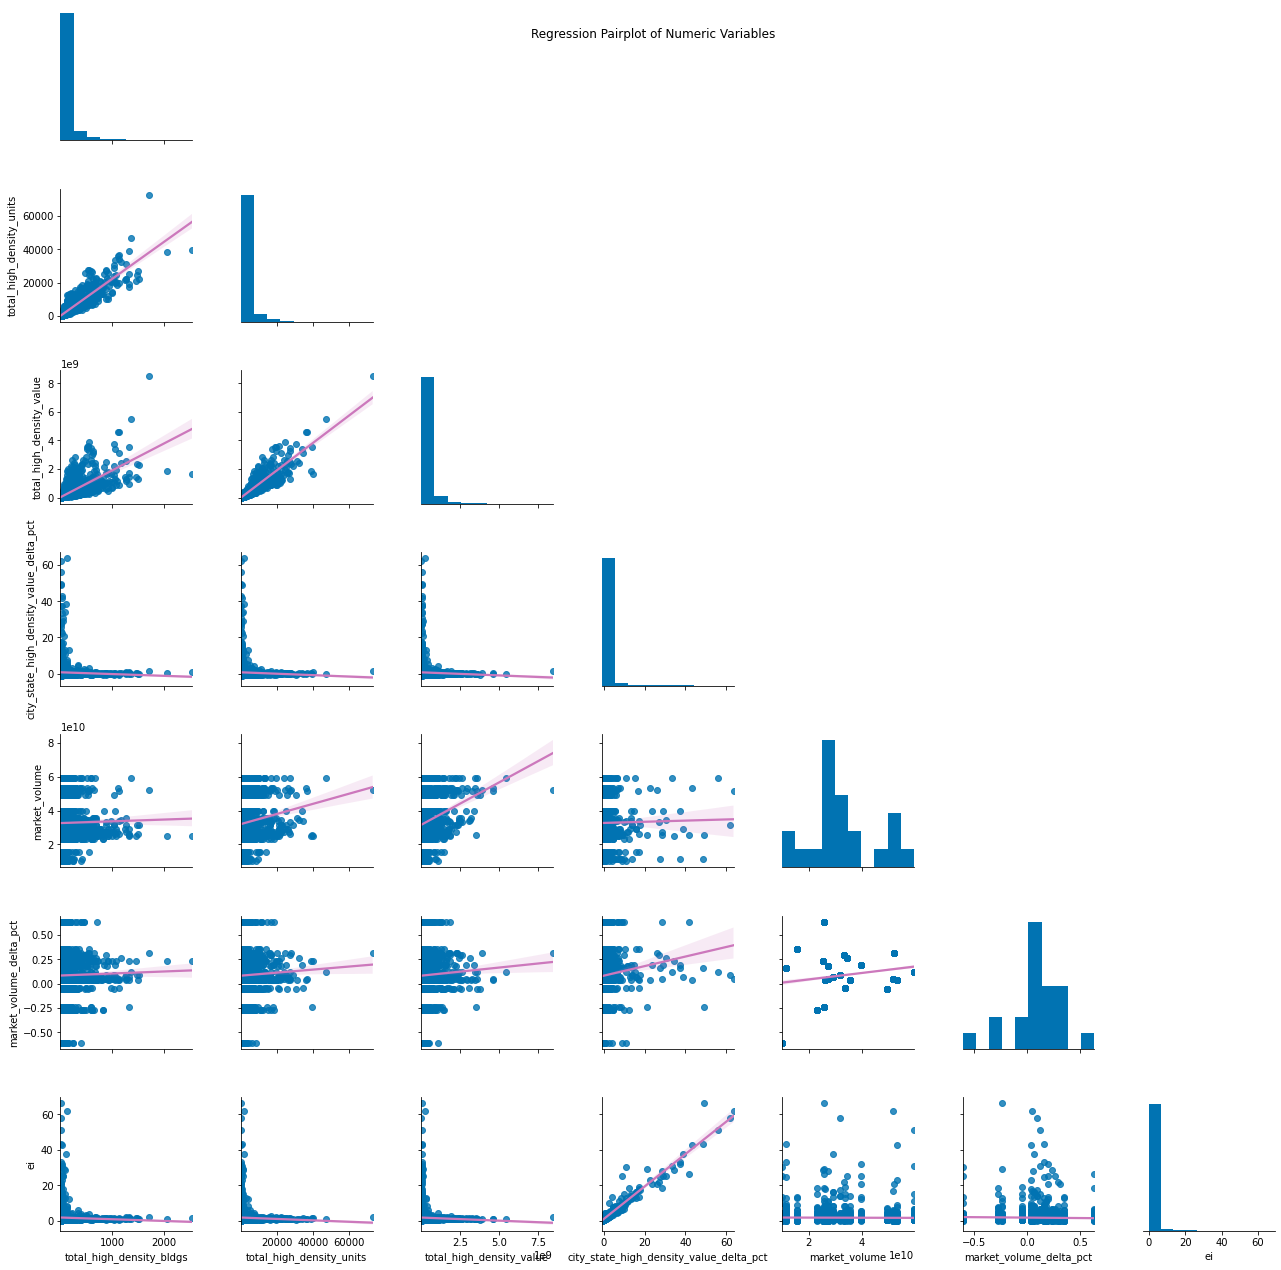

In [62]:
ex.regression_pairplot(df)

**Takeaways**: Since the evolution index is a measure of *relative growth* based on growth rates calculated using market valuation the sheer quantity of buildings, units, and total value of a market is does not appear to be correlated with the evolution index. The specific market growth rate is positively correlated with the evolution index as one would expect since the evolution index is a measure of relative growth. The total number of units positively correlated with the quantity of buildings, and the same goes for the valuation of a market and the units. Total market volume is positively correlated as with the valuation metric as one would expect since total market volume is calulated using the market valuation.

Okay. We believe our exploration of these clusters, while not all-encompassing, is sufficient to press forward with label creation. 

### Clustering Conclusions

* It seems that the most potentially profitable markets are those in clusters 1 and 3; however, we need to be able to predict which markets will move into the top performing clusters *before* the significant growth happens.

* We know that clusters 0 and 4 are usually the underperforming markets. As shown above, it is common for a market to transition from low performing to high performing over time. If we can predict those patterns, we can train a model to predict future growth.

* Real estate is a long-term game. In order to maximize returns for our stakeholder, we should label markets that TestFit should target *two years before* we predict a multifamily housing boom. 

---

## Label Creation

Since we have the cluster a specific market occupies in time, we can create a feature for the cluster a market will occupy two years into the future by shifting the current cluster value back two observations. Using our `create_model_labels` function we will do just that below!

In [63]:
df = pr.create_model_labels(df, centroids)
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head(22)

Our DataFrame contains 2,860 observations and 21 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg_x,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei_x,city_state,cluster,test_future_cluster,should_enter,avg_units_per_bldg_y,ei_y
0,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,1,0.0,False,0.023700,1.710680
1,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0,5.0,False,0.134099,-0.882271
2,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0,5.0,False,0.134099,-0.882271
3,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,5,5.0,False,-0.995691,0.127961
4,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,1.110072,Albany_NY,5,5.0,False,-0.995691,0.127961
5,Albany,NY,2003,44.0,554.0,37765000.0,12.590909,8.582955e+05,68167.870036,-0.063830,0.166316,0.274381,2.305050e+10,-0.272741,1.752307,Albany_NY,5,5.0,False,-0.995691,0.127961
6,Albany,NY,2004,61.0,614.0,54101000.0,10.065574,8.869016e+05,88112.377850,0.386364,0.108303,0.432570,2.723856e+10,0.181691,1.212305,Albany_NY,5,0.0,False,-0.995691,0.127961
7,Albany,NY,2005,113.0,1294.0,104380000.0,11.451327,9.237168e+05,80664.605873,0.852459,1.107492,0.929354,3.435308e+10,0.261193,1.529785,Albany_NY,5,2.0,False,-0.995691,0.127961
8,Albany,NY,2006,34.0,494.0,52148000.0,14.529412,1.533765e+06,105562.753036,-0.699115,-0.618238,-0.500402,3.549408e+10,0.033214,0.483537,Albany_NY,0,2.0,False,0.134099,-0.882271
9,Albany,NY,2007,71.0,981.0,98096000.0,13.816901,1.381634e+06,99995.922528,1.088235,0.985830,0.881108,3.375194e+10,-0.049083,1.978203,Albany_NY,2,4.0,False,0.231324,0.344536


By examining the first 22 observations of our DataFrame above we can demonstrate the method by which we created our labels. Essentially, we are labeling *emgerging markets only*. Our label feature (`should_enter`) is indicating that our stakeholder should enter markets where the current cluster is a low performing cluster, but the future cluster is going to be a higher performing cluster. An example of this can be seen on index 11 where the `cluster` feature is a 4, but the `test_future_cluster` is a 1 and the `should_enter` feature (our label) is `True`.

Now that we have some useful labels, let's explore our data.

---

### Label Exploration

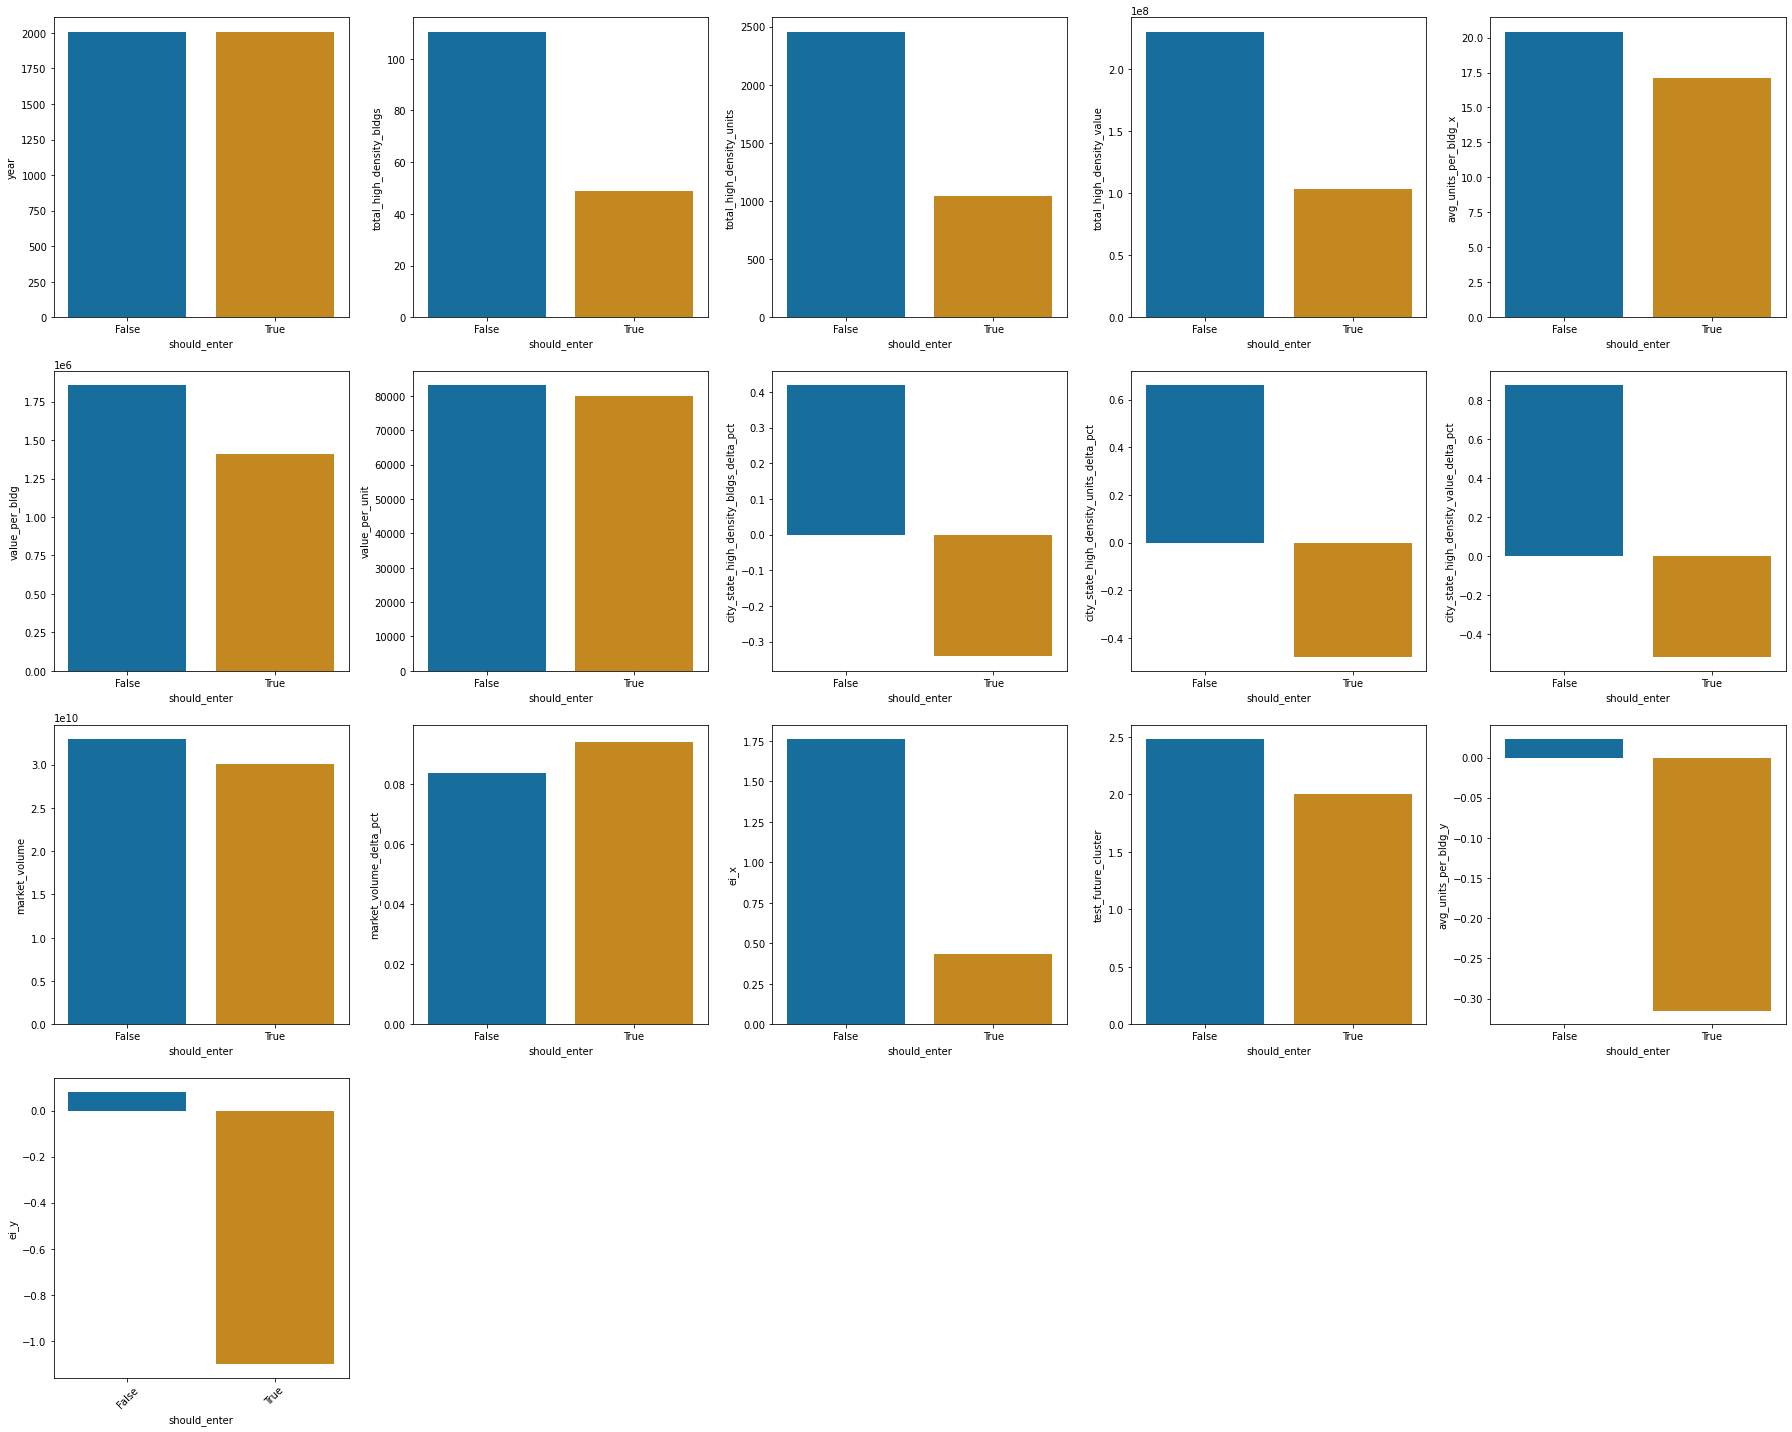

In [64]:
f = plt.figure(figsize=(25,20))
continuous_data = df.select_dtypes(include=["int", "float"])

for count, element in enumerate(continuous_data):
    f.add_subplot(4,5, count+1)
    sns.barplot(data=df, x="should_enter", y=element, ci=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Takeaways**: From the graph above, we see that there are certain numerical features that actually differ greatly by the different target values. 

We predict the the following variables will likely lead to the most effective model, because they show a big difference in overall value when comparing the target variables:

* `ei_x`
* `avg_units_per_bldg_x`
* `cluster`
* `total_high_density_blgs`
* `total_high_density_value`

On the otherhand, we expect that the following variables wouldn't work well for modeling, because there is no distinct value difference:

* `avg_units_per_building`
* `value_per_unit`
* `value_per_building`
* `market_value`
* `year`


We will now do some statistical testing to measure if these values are significantly different, so that we can use them for modeling.

#### Hypothesis Testing with Labels

##### How does the evolution index compare between the labels in value?

$H_0$: There is no difference in the mean `ei` between the two labels.

$H_a$: There is a difference in the mean `ei` between the two labels.

For all of these tests, our alpha will continue to be 0.01.

In [65]:
subgroup_1 = df[df.should_enter == True].ei_x
subgroup_2 = df[df.should_enter == False].ei_x

# T-Test
tstat, pvalue = stats.ttest_ind(subgroup_1, subgroup_2)

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = -5.050559063402469
  p-value = 4.682065251881389e-07

Reject null hypothesis


**Takeaways**: We reject the null hypothesis.

We see that we can reject our null hypothesis, and that there is a significant difference in the evolution index between cities that are labled to enter and cities that are not labeled to enter. We suspect that the cities that are not labeled to enter will likely have a higher evolution index. This would be a good feature for modeling because it can give us a very good understanding of how the market is performing, not only in relation to itself, but also in comparison to the whole market.

Given that we want to focus on markets that are not currently outperforming, but rather that they will in the future, it makes sense for us to use this metric as a way to detect cities that would give us the greatest return on investment. 

##### How does the total number of buildings being constructured compare between the labels in value?

$H_0$: There is no difference in the mean `total_high_density_blgs` between the two labels.

$H_a$: There is a difference in the mean `total_high_density_blgs` between the two labels.

In [66]:
subgroup_1 = df[df.should_enter == True].total_high_density_bldgs
subgroup_2 = df[df.should_enter == False].total_high_density_bldgs

# T-Test
tstat, pvalue = stats.ttest_ind(subgroup_1, subgroup_2)

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = -4.357261144204954
  p-value = 1.3634227570416918e-05

Reject null hypothesis


**Takeaways**: We reject our null hypothesis.

There is a signficant difference in the total number of buildings being built per year. We suspect that, similarly to the evolution index, the values that are not labeled to enter will have a higher number of buildings being built. This is good, as we are trying to identify markets that are emerging, and so we want to target those markets that haven't yet experienced a boom. This feature would be extremely useful in modeling to help get an indication of how the market is performing. 

##### How does the total amount of money being spent to construct housing building compare between the labels in value?

$H_0$: There is no difference in the mean `total_high_density_value` between the two labels.

$H_a$: There is a difference in the mean `total_high_density_value` between the two labels.

In [67]:
subgroup_1 = df[df.should_enter == True].total_high_density_value
subgroup_2 = df[df.should_enter == False].total_high_density_value

# T-Test
tstat, pvalue = stats.ttest_ind(subgroup_1, subgroup_2)

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = -3.506240020115359
  p-value = 0.000461481608244116

Reject null hypothesis


**Takeaways**: We reject our null hypothesis.

There is a signficant difference in the total number of dollars being spent per year. Similarly to the metric that looks at the total number of buildings, this is an extremly useful value that can help us better understand how the market is performing. Additionally, we can use these two values together to get an understanding of how expensive property building might be. Markets where cost of investment is really high might mean that markets are nearing a drop in investment, where as markets where buildings are cheaper to built might be on the verge of a peak. 

### Label Creation Conclusions

We see that there some values that definitively have significant differences between the labels, which will greatly help us with modeling. We will look to use all of these values for modeling, to help us predict emerging markets. 

Below are some additional observations:

* It would useful to see if there is a relationship between labels and clusters. However, given that clusters were used to create labels, there is no point in doing a chi<sup>2</sup> contingency test. 
* It would also be useful for modeling if we could use the average number of units per building feature. We can't test it for a significant difference, however, because that feature is already an average. 
* Even though it seems that there is a difference in market value between the two labels, we believe that this information is captured by the evolution index, and as such we decided not to use it for modeling.
* Similarly to what it is stated above, we decided not to use features that measure the individual market's percent change, as we believe the evolution index better captures this information. 
* We did not test `total_high_density_units` because we believe this information is already captured by the `avg_units_per_bldg` feature. While the same could be said about `total_high_density_bldgs`, we still want to use this feature for modeling, as it can give us an indication of the value of the markets, as well as the relative size of the markets.

Wow, a lot happened in this Preprocessing section. Let's breifly review what we covered

## Preprocessing Conclusions

* Our main issue heading into preprocessing was the lack of labels in our data set. Without labeled data, supervised machine learning is impossible.
* We solved this problem by clustering our data to uncover groups of alike observations in our data using the evolution index and average units per building.
* By exploring our clusters and conducting statistical testing, we reinforced our assumptions of the unique characteristics of each cluster.
* Then we created labels using our clusters to identify emerging markets.
* Finally, we conducted some label-specific exploration and statistical testing in order to determine the best features for our classification model.

Now that we have labels, we are ready to proceed with modeling. Time to shine!

-----

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "total_high_density_bldgs", "total_high_density_value"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with *very little investment* needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the positive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values. Initially, about 7% of our data had a positive label. After oversampling, we have increased the positive value to be ~25% of the total population.

As we begin to model, we want to ensure that the changes or manipulations that we made to the data during the exploration phase are appropriate for modeling. As such, we will be replicating the necessary processes using the `permits_preprocessing_mother_function` to read the data into a new dataframe. 

For modeling, we are actually calling 
```Python
    modeling = True
```
This allows us to perform all the actions through our preprocessing phase, in addition to the following steps:

1. Keep only the features that we want to use for modeling, using the `features_for_modeling` variable below
1. Scale the data, using a `MinMaxScaler`
1. Split the data into a train, validate, test
1. Create our X and y variables, using the `label_feature` variable to identify our target variable (the variable we want to predict)

In [68]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "total_high_density_bldgs", "total_high_density_value"]
label_feature = "should_enter"

In [69]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = pr.permits_preprocessing_mother_function(modeling=True, features_for_modeling=features_for_modeling, label_feature=label_feature)

As we run our models, we want to keep track of how they are performing, especially in comparison to each other, so we will create a new dataframe to store how accurate each model is. 

In [70]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})
recall_value = "True"

## Decision Tree

In order to ensure that we are selecting the best models, with the best hyperparameters possible, we will use our `run_clf_loop` function. This function will train a decision tree model with our train data, and then get an accuracy and recall score. We will also get an accuracy score for our validate data, so that we can reduce the risk of overfitting the model. We set the `max_depth` for our model using the max_range hyperparamenter.

In [71]:
mo.run_clf_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

Max_depth = 1, accuracy_score = 0.77. validate_score = 0.75, recall = 1.00
Max_depth = 2, accuracy_score = 0.81. validate_score = 0.79, recall = 1.00
Max_depth = 3, accuracy_score = 0.83. validate_score = 0.80, recall = 1.00
Max_depth = 4, accuracy_score = 0.84. validate_score = 0.79, recall = 0.68
Max_depth = 5, accuracy_score = 0.84. validate_score = 0.81, recall = 0.98
Max_depth = 6, accuracy_score = 0.87. validate_score = 0.82, recall = 0.81
Max_depth = 7, accuracy_score = 0.87. validate_score = 0.82, recall = 0.82
Max_depth = 8, accuracy_score = 0.89. validate_score = 0.84, recall = 0.84
Max_depth = 9, accuracy_score = 0.90. validate_score = 0.85, recall = 0.88
Max_depth = 10, accuracy_score = 0.91. validate_score = 0.85, recall = 0.88
Max_depth = 11, accuracy_score = 0.92. validate_score = 0.86, recall = 0.87
Max_depth = 12, accuracy_score = 0.93. validate_score = 0.85, recall = 0.82
Max_depth = 13, accuracy_score = 0.94. validate_score = 0.88, recall = 0.86
Max_depth = 14, accur

Above we see that our best result is at a `max_depth` of 3, as this is when we get our highest score on our validate dataset, without being too overfit. 

In [72]:
clf, y_pred = mo.run_clf(train_scaled, y_train, 3)
predictions["decision_tree"] = y_pred

In [73]:
accuracy_score, matrix, report = mo.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.83
       False  True 
False   1039    310
True       0    448


,False,True,accuracy,macro avg,weighted avg
precision,1.000000,0.591029,0.82749,0.795515,0.898042
recall,0.770200,1.000000,0.82749,0.885100,0.827490
f1-score,0.870184,0.742952,0.82749,0.806568,0.838465
support,1349.000000,448.000000,0.82749,1797.000000,1797.000000


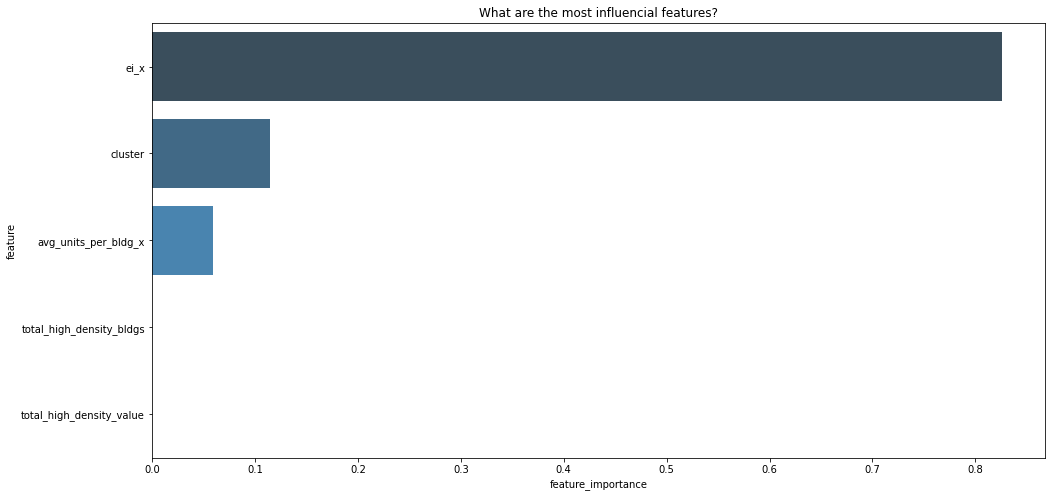

In [74]:
mo.clf_feature_importances(clf, train_scaled)

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature. It appears that `total_high_density_bldgs` and `total_high_density_value` are actually not that useful for decision tree.

## Random Forest

Similarly to what we did above, we will try to implement the best possible random forest model. We will use our loop function to print the accuracy scores at different `max_depth's`. In this case, we kept the number of `min_samples_leafint` at 1. 

In [75]:
mo.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

Max_depth = 1, accuracy_score = 0.77. validate_score = 0.79, recall = 0.14
Max_depth = 2, accuracy_score = 0.85. validate_score = 0.81, recall = 0.77
Max_depth = 3, accuracy_score = 0.86. validate_score = 0.82, recall = 0.81
Max_depth = 4, accuracy_score = 0.88. validate_score = 0.83, recall = 0.86
Max_depth = 5, accuracy_score = 0.90. validate_score = 0.84, recall = 0.91
Max_depth = 6, accuracy_score = 0.92. validate_score = 0.86, recall = 0.93
Max_depth = 7, accuracy_score = 0.95. validate_score = 0.88, recall = 0.97
Max_depth = 8, accuracy_score = 0.97. validate_score = 0.89, recall = 0.98
Max_depth = 9, accuracy_score = 0.98. validate_score = 0.90, recall = 1.00
Max_depth = 10, accuracy_score = 0.99. validate_score = 0.91, recall = 1.00
Max_depth = 11, accuracy_score = 1.00. validate_score = 0.91, recall = 1.00
Max_depth = 12, accuracy_score = 1.00. validate_score = 0.91, recall = 1.00
Max_depth = 13, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
Max_depth = 14, accur

We see above that the best validate score is at a `max_depth` of 2, without being too overfit. 

In [76]:
rf, y_pred = mo.run_rf(train_scaled, y_train, 1, 2)
predictions["random_forest"] = y_pred

In [77]:
accuracy_score, matrix, report = mo.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.85
       False  True 
False   1188    161
True     103    345


,False,True,accuracy,macro avg,weighted avg
precision,0.920217,0.681818,0.853088,0.801018,0.860783
recall,0.880652,0.770089,0.853088,0.825371,0.853088
f1-score,0.900000,0.723270,0.853088,0.811635,0.855941
support,1349.000000,448.000000,0.853088,1797.000000,1797.000000


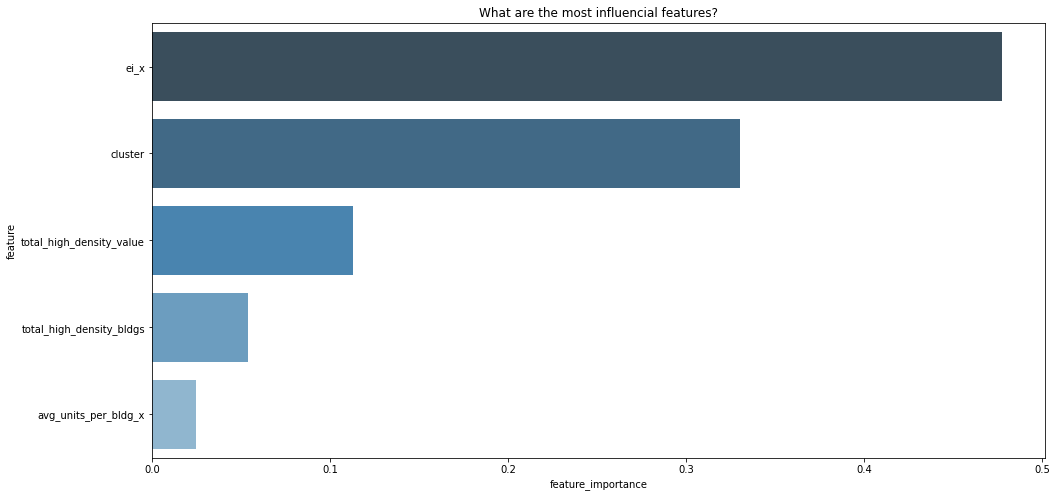

In [78]:
mo.rf_feature_importance(rf, train_scaled)

Similarly, for random forest, the `evolution_index` is the most influencial feature, along with the clusters. It seem's the `total_high_density_blgs` is again one of the least influencial features.

## KNN

In the case of the K-nearest neighbor, we will be looking at the number of neighbors that the model will use to create a prediction. We can expect this model to work best, because of two reasons:

1. The shape of the data actually will lend it self very well to this type of modeling, as we can expect similar cities to have similar values.
1. Some of the features that we are using for modeling have some correlation with each other. Usually, this can be a problem during modeling, as most models expect features to not be correlated to each others. However, KNN doesn't have a problem with this, meaning that we can get the most out of modeling by using all the features we need.

In [79]:
mo.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

k_n = 1, accuracy_score = 1.00. validate_score = 0.93, recall = 1.00
k_n = 2, accuracy_score = 0.99. validate_score = 0.89, recall = 0.96
k_n = 3, accuracy_score = 0.93. validate_score = 0.87, recall = 0.97
k_n = 4, accuracy_score = 0.91. validate_score = 0.84, recall = 0.83
k_n = 5, accuracy_score = 0.91. validate_score = 0.84, recall = 0.88
k_n = 6, accuracy_score = 0.89. validate_score = 0.84, recall = 0.78
k_n = 7, accuracy_score = 0.88. validate_score = 0.83, recall = 0.87
k_n = 8, accuracy_score = 0.88. validate_score = 0.83, recall = 0.81
k_n = 9, accuracy_score = 0.88. validate_score = 0.84, recall = 0.87
k_n = 10, accuracy_score = 0.88. validate_score = 0.83, recall = 0.80
k_n = 11, accuracy_score = 0.88. validate_score = 0.85, recall = 0.86
k_n = 12, accuracy_score = 0.87. validate_score = 0.84, recall = 0.80
k_n = 13, accuracy_score = 0.88. validate_score = 0.84, recall = 0.86
k_n = 14, accuracy_score = 0.87. validate_score = 0.84, recall = 0.80


As we can see above, our model peforms best at a k-neighbor of 1. This has been the best score so far on our valdiate data.

In [80]:
knn, y_pred = mo.run_knn(train_scaled, y_train, 1)
predictions["knn"] = y_pred

In [81]:
accuracy_score, matrix, report = mo.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 1.00
       False  True 
False   1349      0
True       0    448


,False,True,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,1349.0,448.0,1.0,1797.0,1797.0


Now that we have finished modeling, we will go back into our predictions dataframe, and evaluate which model performed the best. We will then select the best model for evaluation, to ensure that the model is not overfit.

In [82]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.75
Decision_Tree = 0.83
Random_Forest = 0.85
Knn = 1.00


In [83]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 1.00
Random_Forest = 0.77
Knn = 1.00


In [84]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["precision"]:.2f}')

Precision Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.59
Random_Forest = 0.68
Knn = 1.00


## Evaluate

The best performing model is the KNN. It certainly performs better than the rest of the models, and much better than the baseline, meaning that in this case we definitively recommend using a model.

We will evaluate the KNN model with a `K_neighbor` of 1.

In [85]:
knn, y_pred = mo.run_knn(train_scaled, y_train, 1)

In [86]:
y_pred = knn.predict(test_scaled)

In [87]:
accuracy_score, matrix, report = mo.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.91
       False  True 
False    545     56
True      13    186


,False,True,accuracy,macro avg,weighted avg
precision,0.976703,0.768595,0.91375,0.872649,0.924936
recall,0.906822,0.934673,0.91375,0.920748,0.913750
f1-score,0.940466,0.843537,0.91375,0.892002,0.916355
support,601.000000,199.000000,0.91375,800.000000,800.000000


## Modeling Conclusions

We see that KNN achieves a 91% accuracy and a 93% recall_score on test data. This is a really strong model, and we have confidence that we can use it to predict markets that TestFit should enter in 2020 and 2021, given that they are likely going to increase in value over the next two years. 

In the end, we do reject our null hypothesis, and can confidently say that `Evolution_index`, `clusters`, `avg_units_per_building`, `total_high_density_blgs` and `total_high_density_value` are good features to use for modeling, as they can help us understand and evaluate how a city might be peforming, especially in comparison to the rest of the country. The clusters have also been invaluable, as not only did they help create our labels, but they also provide valuable information when it comes to modeling.

----

# Prediction

As part of our deliverables, it is important for our stakeholder that we can come up with a series of recommendations on which markets they should enter in 2020 and 2021. Because of TestFit's business model, they realistically need to enter a market 2 or 3 years before the market actually picks up, as their software is most useful when companies are in the planning stages and trying to secure loans. As such, we need to predict not what market's will be hot in 2020, but rather predict what markets will be hot in 2022 or 2023. 

We will average the data from 2018 and 2019 to create values for 2020 and 2021. Using the K-means cluster we fitted during the exploration, we can create a new cluster prediction on the aggregated values, which we can use for modeling. 

Once the data is scaled and clustered, we can use our KNN model to create a prediction on which cities TestFit should enter in 2020 and 2021.

In order to create our predictions, we will use the `prep_prediction_data`. This function reads in a new dataframe, with none of the manipulations we did during the exploration phase. 

It then add's clusters to the dataframe. 

In [88]:
df, kmeans = mo.prep_prediction_data()

We can see what the dataframe look like below:

In [89]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg_x,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei_x,city_state,cluster,avg_units_per_bldg_y,ei_y
0,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,1,0.023700,1.710680
1,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0,0.134099,-0.882271
2,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0,0.134099,-0.882271
3,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,5,-0.995691,0.127961
4,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,1.110072,Albany_NY,5,-0.995691,0.127961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,0,0.134099,-0.882271
2856,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0,0.134099,-0.882271
2857,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,5,-0.995691,0.127961
2858,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,4,-1.407036,-1.636162


Now that we have a dataframe, we can call the `create_predictions_df` function. This function will take the dataframe, as well as the fitted kmeans object, and our best model. 

The output will be a dataframe, with values calculated for 2021, and new clusters (based on the new calculated values) as well as a label on whether TestFit should look to enter this city by 2021. 

The function also assigns a `recommendation_label` to each observation. This recommendation_label is derived using the predicted `label`, as well as the predicted `cluster` for each observation.

In [90]:
predictions = mo.create_predictions_df(df, kmeans, knn)
print(f"Out of 130 cities, we recommend entering the following {predictions[predictions.label].shape[0]} markets")
predictions[predictions.label]

Out of 130 cities, we recommend entering the following 72 markets


,city_state,ei_x,total_high_density_bldgs,total_high_density_value,avg_units_per_bldg,cluster,label,city,state,recommendation_label
0,Albany_NY,1.202852,48.0,137636000.0,15.854167,5,True,Albany,NY,medium_ROI
1,Albuquerque_NM,2.948283,13.5,13392000.0,12.481481,1,True,Albuquerque,NM,Stable_High
2,Allentown_PA,1.523173,15.0,18912000.0,13.366667,5,True,Allentown,PA,medium_ROI
3,Anchorage_AK,0.973912,21.0,33022500.0,10.309524,5,True,Anchorage,AK,medium_ROI
4,Appleton_WI,0.503518,6.5,8524000.0,13.615385,4,True,Appleton,WI,Best_ROI
...,...,...,...,...,...,...,...,...,...,...
122,Trenton_NJ,0.757433,24.5,15871000.0,11.734694,4,True,Trenton,NJ,Best_ROI
125,Tuscaloosa_AL,1.494644,18.5,102458000.0,29.891892,2,True,Tuscaloosa,AL,medium_ROI
127,Wilmington_NC,1.606273,40.0,134109500.0,26.600000,2,True,Wilmington,NC,medium_ROI
128,Worcester_MA,1.467458,15.5,59748000.0,31.806452,2,True,Worcester,MA,medium_ROI


Given that we had 72 cities that the model recommended entering, we wanted to create a way to further subcategorize our predictions, for easier prioratization. The labels are defined below:

* **Best_ROI**: These are cities that we found will be underperforming the market by 2021, but we predict they will be over performing the market by 2023, so we recommend TestFit prioritizes these markets, as they can offer the greatest potential return on investment.
* **Medium_ROI**: These are citites that we found will be performing about the same as the rest of the U.S. market by 2021, but we predict they will be outperforming the market by 2023. These cities will offer the next best return on investment.
* **Stable_High**: These cities will already by outperforming the market by 2021, but we predict they will continue to be outperforming the market by 2023. While we suspect the return on investment for these cities will be lower, we expect that there might still be some gains from investing in these cities. 
* **Not Recommended to Enter**: Lastly, we have the cities that were labeled by the model as not recommended for entering in 2021. The reason for this is because we suspect that these cities will most likely decrease in value by 2023, and as a result they might not offer the best return on investment.

Using our `create_prediction_graph` function, we can see what the distribution is between our recommendation labels.

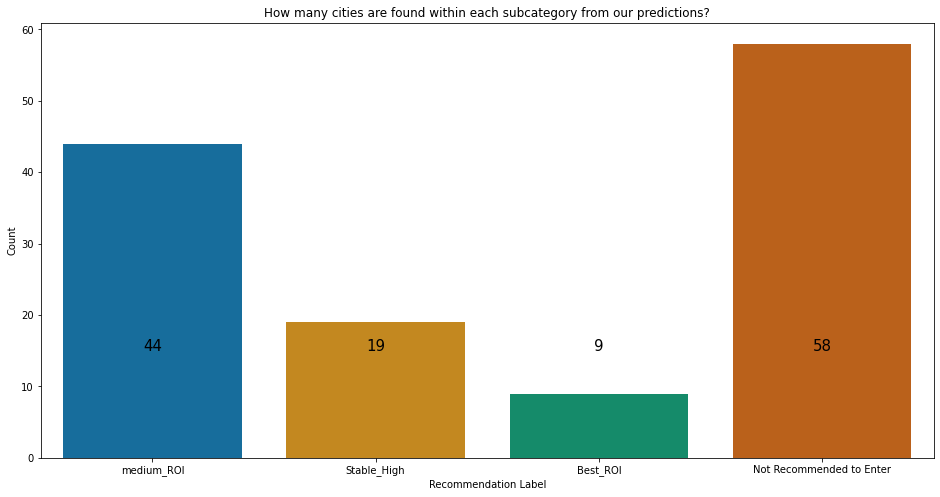

In [91]:
ex.create_prediction_graph(predictions)

In [92]:
print("Markets with greatest return on investment")
print("-------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 0) | (predictions.cluster == 4))].city_state.to_string(index=False))

print("")
print("High density markets with potential for growth")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 5) | (predictions.cluster == 2))].city_state.to_string(index=False))

print("")
print("Markets already hot")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 3) | (predictions.cluster == 1))].city_state.to_string(index=False))

Markets with greatest return on investment
-------------------
    Appleton_WI
 Bloomington_IL
    Columbia_SC
     El Paso_TX
    Florence_AL
    Hartford_CT
      Laredo_TX
  Santa Cruz_CA
     Trenton_NJ

High density markets with potential for growth
------------------
           Albany_NY
        Allentown_PA
        Anchorage_AK
         Bismarck_ND
       Boise City_ID
          Buffalo_NY
           Canton_OH
      Chattanooga_TN
      Clarksville_TN
        Cleveland_OH
 Colorado Springs_CO
         Columbus_GA
          Detroit_MI
       Eau Claire_WI
             Erie_PA
           Fresno_CA
          Greeley_CO
        Green Bay_WI
     Indianapolis_IN
        Iowa City_IA
        Knoxville_TN
        Lancaster_PA
        Lexington_KY
      Little Rock_AR
          Lubbock_TX
       Manchester_NH
           Naples_FL
        New Haven_CT
     Philadelphia_PA
       Providence_RI
       Rapid City_SD
             Reno_NV
         Richmond_VA
        Riverside_CA
        Roch

Can we quantify the potential average growth for cities based on the clusters they were given, and based on the prediction of whether cities will be an emerging market by 2023?

We will use our `print_predictions_value` function to help answer this question. The function looks at the historical data, and see how much, on average, cities have grown in value when changing between clusters. For example, for emerging markets, we look at markets that at one points where `cluster_0` or `cluster_4`. We record their `total_high_density_value`, and then we calcualte the percent change of this value (or the difference in value) when compared to cities with a high cluster, like `cluster_3` or `cluster_1`.

In [93]:
# How much do we expect emerging markets (or markets with high ROI) to actually grow by 2023?

mo.print_predictions_value_emerging(df)

We expect emerging markets to increase, on average, by 333% over the next two years
We expect emerging markets to increase, on average, by $332,821,996 over the next two years


In [94]:
# How much do we expect medium markets to actually grow by 2023?

mo.print_predictions_value_medium(df)

We expect medium markets to increase their investment, on average, by 166%
We expect medium markets to increase their investment, on average, by $270,060,645


In [95]:
# How much do we expect declining markets to actually decline by 2023?

mo.print_predictions_value_declining(df)

We expect declining markets to decrease their investment, on average, by -77%
We expect declining markets to decrease their investment, on average, by $-332,821,996


# Conclusion

## Executive Summary

1. Objective - We identified major metropolitan markets that are likely to experience significant high-density, multifamily housing infrastructure growth over the next two years.
2. Solution - By conducting exploratory analysis on historical high-density, multifamily housing data, we unconvered trends that aided in the creation of a machine learning model used to predict markets that are likely to see significant infrastructure growth over the next two years.
3. Result - A machine learning model that can predict emerging high-denisty, multifamily housing markets with 91% accuracy.

## Recommendation Summary

The model has recommended 43 cities to enter in 2020 and 2021. Again, these are not markets that are considered "hot" right now, but rather they are markets that will likely increase in value and activity over the next two to three years, so 2020 and 2021 would be the optimal time to enter the market, as developers and cities begin to work on granting permits and securing funding for new multifamily housing construction projects.

We have further broken the recommendations into three groups, to further help with decision making. The first group are markets that are currently performing well below the rest of the market, and have low density populations. These are the markets that are best poised to quickly grow, and as such we highly recommend prioritizing these markets. 

The second group is markets that already likely have higher density (higher average units per building), however, they are also investing less than the rest of the market. These markets will likely also see a huge a surge in growth as well, and are still an opportunity that TestFit should take advantage of. 

The last group is the markets that are currently performing above the rest of the market, and are likely to continue that trend for the next two years. These markets might be more challenging to penetrate, as they would have already undergone significant growth and a high level of investment. This means that these markets might be more established, and the competition might be higher, however these are also potentially the markets with the highest levels of investment in terms of dollars, which means a higher opportunity for TestFit.

Overall, we think all these markets would be worth TestFits investment, as they have great potential for expansion. The approach to the different groups might vary, but ultimately we are confident that they will give a good return on investment.

## Suggestions for improvement

### Add population data

We found additional census data that contains population data for major metropolitan areas in the U.S. TestFit, our stakeholder, benefits from markets that are building a high number of multifamily housing buildings, since their software specifically helps architects and companies with the preparation process. As such, understanding population trends could give us a more robust understanding of which cities we would expect to see significant growth.

### Adding markets that are likely to continue growing

For this iteration of the project, we decided to only include labels of markets we considered "emerging_markets". This means markets that were performing well below the average (when compared to the market), but will see a big spike in investment and growth in the future. We were able to identify markets that were doing well (above average) and were likely going to continue performing well. These would still be viable markets for TestFit, however, we decided to exclude them from the model because the group was significantly larger than the "emerging_markets" group, and during modeling we found that the model was mostly focusing on the stable_high markets. 

We decided that the emerging markets would likely provide the highest return on investment, as these markets would go from underperforming, to high performing.

If we had more time, we would recommend either working on optimizing the existing model so that it could predict for both emerging and stable high markets. This could be accomplished by oversampling the "emerging_markets" samples so that the model high equally predict both targets. Additionally, another alternatively is to have two separate models which recommends markets to enter, and becasue they are individually tailored, they can both be optimized for accuracy and recall.

## Thanks

Thank you for reading our final report. We would like to thank TestFit for the opportunity to work on this project, and the Codeup staff for their ongoing support.

If you would like to learn more about our team, please follow the links at the top of this notebook.